In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import scipy.stats as st
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sns.set_theme(font_scale = 1, style = 'ticks')



# Plot results for figure 3 and supplements

In [2]:
git_folder = Path('../..')
figure_folder = git_folder / 'Figures' /'KEIO'
figure_folder.mkdir(parents=True, exist_ok=True)
data_folder_1 = git_folder / 'data' / 'this_project' / '2_keio_strains_screening'
fn_tubes = data_folder_1 / '2A_ecoli_KO_screen_tubes_OD.csv'
fn_wells = data_folder_1 / '2B_ecoli_KO_screen_wells_OD.csv'

z_scores_fn = data_folder_1 / '2E_exometabolome_zscores.csv'
uM_fn = data_folder_1 / '2C_exometabolome_uM.csv'
counts_fn = data_folder_1 / '2D_exometabolome_counts.csv'

# Plot exometabolome comparisons

In [3]:
df_uM = pd.read_csv(uM_fn, index_col=0, nrows=27)
df_z_scores = pd.read_csv(z_scores_fn, index_col=0)
df_counts = pd.read_csv(counts_fn, index_col=0)


In [4]:
# Drop metabolites not detected in any condition
df_uM = df_uM.loc[:, df_uM.notna().any()]
df_z_scores = df_z_scores.loc[:, df_z_scores.notna().any()]
df_counts = df_counts.loc[:, df_counts.notna().any()]

In [5]:
# Remove outliers
df_counts.at[15, 'Adenosine'] = np.nan
df_counts.at[15, 'Choline'] = np.nan
df_counts.at[15, 'Proline'] = np.nan
df_counts.at[18, 'Arginine'] = np.nan
df_counts.at[18, 'Proline'] = np.nan
df_counts.at[0, 'Pyrimidine'] = np.nan
df_counts.at[2, 'Pyrimidine'] = np.nan



In [6]:
# move pool samples to a separate df
df_uMpools = df_uM.loc[df_uM.Sample_id.str.contains('pool')]
df_uMsamples = df_uM.loc[~df_uM.Sample_id.str.contains('pool')]

df_z_scores_pools = df_z_scores.loc[df_z_scores.Sample_id.str.contains('pool')]
df_z_scores_samples = df_z_scores.loc[~df_z_scores.Sample_id.str.contains('pool')]

df_counts_pools = df_counts.loc[df_counts.Sample_id.str.contains('pool')]
df_counts_samples = df_counts.loc[~df_counts.Sample_id.str.contains('pool')]

In [7]:
# Drop metabolites only detected in one well
df_uMsamples = df_uMsamples.loc[:, df_uMsamples.notna().sum() > 1]

## Plot pairwise comparison of strain vs WT


In [8]:
df_uMsamples.columns

Index(['Sample_id', 'Leucine', 'Gamma-aminobutyrate', 'Proline', 'Valine',
       'Beta-alanine', 'Alanine', 'Alpha-aminoadipate', 'Glutamine',
       'Glutamate', 'Asparagine', 'Aspartate', 'Lactate',
       'Fructose-6-phosphate', 'Malate', 'Glucose-6-phosphate',
       'Cis-aconitate', 'Citrate', 'Isocitrate', 'Trans-aconitate', 'OD ID',
       'Strain', 'OD', 'Replicate', 'Hours'],
      dtype='object')

In [9]:
exo_strains = sorted(df_uMsamples.Strain.unique())
exo_strains_x_wt = [x for x in exo_strains if 'WT' not in x]
exo_strains_x_wt = [x for x in exo_strains_x_wt if 'lacA' not in x] + ['lacA']

uM_metabolites = sorted(df_uMsamples.columns[1:-5])
z_metabolites = sorted(df_z_scores.columns[1:-5])

In [10]:
df_uMsamples.set_index('Strain', inplace=True)
df_counts_samples.set_index('Strain', inplace=True)


In [11]:
strain_cmap =plt.get_cmap('tab10', 9)
strain_colors = {
    'WT': strain_cmap(0),
    'aceE': strain_cmap(1),
    'cyoD': strain_cmap(2),
    'nuoA': strain_cmap(3),
    'pgi': strain_cmap(4),
    'rpe': strain_cmap(5),
    'sucB': strain_cmap(7),
    'lacA': strain_cmap(6),
}


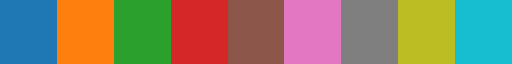

In [12]:
strain_cmap

## Compute p-values

In [13]:

# Collect p-values and corresponding (strain, metabolite) pairs
strain_metabolite_pairs = []
adjusted_p_values = []
all_p_values = []
uM_mean_std_dict = {}
for strain in exo_strains:
    p_values = []
    for metabolite in uM_metabolites:
        s_values = df_uMsamples.loc[strain, metabolite]
        wt_values = df_uMsamples.loc['WT', metabolite]
        s_mean = s_values.mean()
        wt_mean = wt_values.mean()
        s_std = s_values.std()
        wt_std = wt_values.std()
        uM_mean_std_dict[strain, metabolite] = {'Mean':s_mean, 'Std':s_std, 'N':len(s_values)}
        
        # if not np.isnan([s_mean, wt_mean, s_std, wt_std]).any():
        ttest_res = st.ttest_ind(s_values, wt_values, equal_var=False, alternative='two-sided')
        if not np.isnan(ttest_res.pvalue):
            p_values.append(ttest_res.pvalue)
            strain_metabolite_pairs.append((strain, metabolite))
        
    # Adjust p-values using the Benjamini-Hochberg procedure
    adjusted_p_values_s = multipletests(p_values, method='fdr_bh')[1]
    adjusted_p_values += adjusted_p_values_s.tolist()
    all_p_values += p_values
    # break
# Create a dictionary with adjusted p-values
adjusted_p_values_dict = {
    pair: adj_p for pair, adj_p in zip(strain_metabolite_pairs, adjusted_p_values)
}
p_values_dict = {
    pair: p_val for pair, p_val in zip(strain_metabolite_pairs, all_p_values)
}


In [14]:

# Collect p-values and corresponding (strain, metabolite) pairs
strain_metabolite_pairs = []
adjusted_p_values = []
all_p_values = []
counts_mean_std_dict = {}
all_mean_differences = {}
log_diffs = {}
for strain in exo_strains:
    p_values = []
    for metabolite in z_metabolites:
        s_values = df_counts_samples.loc[strain, metabolite]
        wt_values = df_counts_samples.loc['WT', metabolite]
        s_mean = s_values.mean()
        wt_mean = wt_values.mean()
        s_std = s_values.std()
        wt_std = wt_values.std()
        counts_mean_std_dict[strain, metabolite] = {'Mean':s_mean, 'Std':s_std, 'N':len(s_values)}
        # if not np.isnan([s_mean, wt_mean, s_std, wt_std]).any():
        if strain != 'WT':
            log_diffs[strain, metabolite] = np.log10(s_mean) - np.log10(wt_mean)
            all_mean_differences[strain, metabolite] = s_mean - wt_mean
        ttest_res = st.ttest_ind(s_values, wt_values, equal_var=False, alternative='two-sided')
        if not np.isnan(ttest_res.pvalue):
            p_values.append(ttest_res.pvalue)
            strain_metabolite_pairs.append((strain, metabolite))
        
        # print(strain, metabolite, ttest_res, s_values, wt_values)
    # Dont add WT vs WT in all the values
    # Adjust p-values using the Benjamini-Hochberg procedure
    adjusted_p_values_s = multipletests(p_values, method='fdr_bh')[1]
    adjusted_p_values += adjusted_p_values_s.tolist()
    all_p_values += p_values
    # break
# Create a dictionary with adjusted p-values
counts_adjusted_p_values_dict = {
    pair: adj_p for pair, adj_p in zip(strain_metabolite_pairs, adjusted_p_values)
}
counts_p_values_dict = {
    pair: p_val for pair, p_val in zip(strain_metabolite_pairs, all_p_values)
}


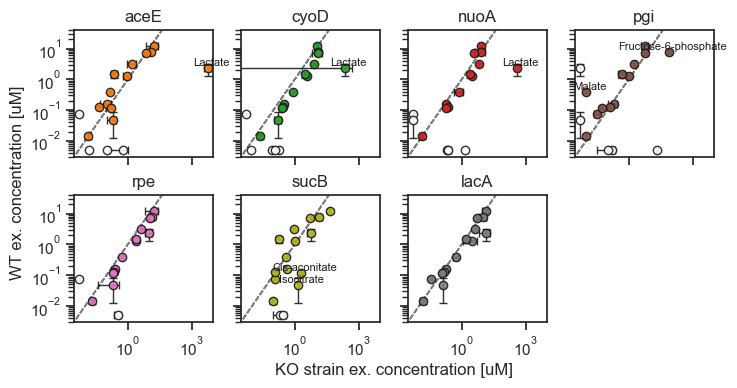

In [15]:
from matplotlib.ticker import LogLocator, NullFormatter

fig, axes = plt.subplots(2, 4, figsize=(8, 4), sharey=True, sharex = True)
axes = axes.flatten()
for i, strain in enumerate(exo_strains_x_wt):
    for j, m in enumerate(uM_metabolites):
        # print(strain, m)
        ax = axes[i]
        ax.set_title(strain)
        ax.set_xscale('log')
        ax.set_yscale('log')
        s_mean = uM_mean_std_dict[strain, m]['Mean']
        s_std = uM_mean_std_dict[strain, m]['Std']
        s_n = uM_mean_std_dict[strain, m]['N']
        wt_mean = uM_mean_std_dict['WT', m]['Mean']
        wt_std = uM_mean_std_dict['WT', m]['Std']
        wt_n = uM_mean_std_dict['WT', m]['N']

        if np.isnan(s_mean) and np.isnan(wt_mean):
            continue

        try:
            pvalue = p_values_dict[strain, m]
        except:
            pvalue = np.nan
        
        # if pvalue < 0.05:
        #     print(f'{strain} {m} {ttest_res.pvalue:.2e}')
        #     mecolor = 'k'
        # else:
        #     mecolor = 'gray'

        mecolor = 'k'
        if np.isnan(s_mean) or np.isnan(wt_mean):
            c = 'w'
            if np.isnan(s_mean):
                s_mean = 5e-3
            if np.isnan(wt_mean):
                wt_mean = 5e-3
        else:
            c = strain_colors[strain]


        ax.errorbar(
            x=s_mean,
            y = wt_mean,
            xerr=s_std,
            yerr=wt_std,
            fmt='o',
            # color='black',
            capsize=3,
            elinewidth=1,
            alpha=0.9,
            markeredgecolor=mecolor,
            ecolor=mecolor,#wt_mets_colors[m],
            c = c#strain_colors[strain],
        )
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.plot([1e-4, 1e3], [1e-4, 1e3], ls = '--',c = 'gray', alpha=0.5, zorder=-10, lw = 1)


        # Annotate
        if np.abs(np.log10(uM_mean_std_dict[strain, m]['Mean']) - np.log10(uM_mean_std_dict['WT', m]['Mean'])) > 1:
            ax.annotate(
                m,
                xy=(uM_mean_std_dict[strain, m]['Mean'], uM_mean_std_dict['WT', m]['Mean']),
                xytext=(uM_mean_std_dict[strain, m]['Mean']*1.5, uM_mean_std_dict['WT', m]['Mean']*1.5),
                fontsize=8,
                ha='center',
                va='center',
                color = 'k', #strain_colors[strain],
            )
        # ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(3e-3, 1e4)
        ax.set_ylim(3e-3, 4e1)
        # ax.set_ylim(-4, 4)
        # Increase the number of ticks on the x-axis
        ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=4))  # Major ticks
        # ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=6))  # Minor ticks

axes[-1].remove()
fig.supylabel('WT ex. concentration [uM]', fontsize=12)
fig.supxlabel('KO strain ex. concentration [uM]', fontsize=12)
# plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.3, left = 0.1, bottom=0.15)
plt.savefig(figure_folder / 'KEIO_exometabolome_wt_comparison_v1.pdf', bbox_inches='tight')

# Repeat, but with counts

In [16]:
counts_mean_std_dict

{('WT', '1, 3-diaminopropane'): {'Mean': np.float64(3182.921074350143),
  'Std': 472.00262802840047,
  'N': 3},
 ('WT', '2, 5-dihydroxybenzoate'): {'Mean': np.float64(21305.54673111277),
  'Std': 3360.2592067157616,
  'N': 3},
 ('WT', '2-hydroxybutyrate'): {'Mean': np.float64(1245.8139064551399),
  'Std': 99.3774561686364,
  'N': 3},
 ('WT', '2-hydroxyglutaric acid'): {'Mean': np.float64(4703.135330552873),
  'Std': 396.5261877723813,
  'N': 3},
 ('WT', '2-oxobutanoate/acetoacetate'): {'Mean': nan, 'Std': nan, 'N': 3},
 ('WT',
  '3-(4-hydroxyphenyl)pyruvate'): {'Mean': np.float64(1780.4709022286434), 'Std': 68.94937548451763, 'N': 3},
 ('WT', '3-hydroxyanthranilate'): {'Mean': np.float64(7937.131061200321),
  'Std': 718.4786428236852,
  'N': 3},
 ('WT', '3-hydroxybutyrate'): {'Mean': np.float64(3182.3764590937267),
  'Std': 71.0512955006231,
  'N': 3},
 ('WT', '3-hydroxyglutaric acid'): {'Mean': np.float64(3818.45646063192),
  'Std': 1008.4370064940097,
  'N': 3},
 ('WT', '3-hydroxyphe

aceE 1, 3-diaminopropane (np.float64(1.0), np.float64(0.4980392156862745), np.float64(0.054901960784313725), np.float64(1.0)) 2923.2761165964134 3182.921074350143 0.6185867811373047 w
aceE 2, 5-dihydroxybenzoate (np.float64(1.0), np.float64(0.4980392156862745), np.float64(0.054901960784313725), np.float64(1.0)) 15102.641606100698 21305.54673111277 0.19127376073526775 w
aceE 2-hydroxybutyrate (np.float64(1.0), np.float64(0.4980392156862745), np.float64(0.054901960784313725), np.float64(1.0)) 14038.521429678447 1245.8139064551399 0.16138160636884796 w
aceE 2-hydroxyglutaric acid (np.float64(1.0), np.float64(0.4980392156862745), np.float64(0.054901960784313725), np.float64(1.0)) 15173.996578062333 4703.135330552873 0.07028783597262146 w
aceE 2-oxobutanoate/acetoacetate w 6481.957968353466 10 nan gray
aceE 3-(4-hydroxyphenyl)pyruvate (np.float64(1.0), np.float64(0.4980392156862745), np.float64(0.054901960784313725), np.float64(1.0)) 604.0743415597013 1780.4709022286434 0.046289463077670616

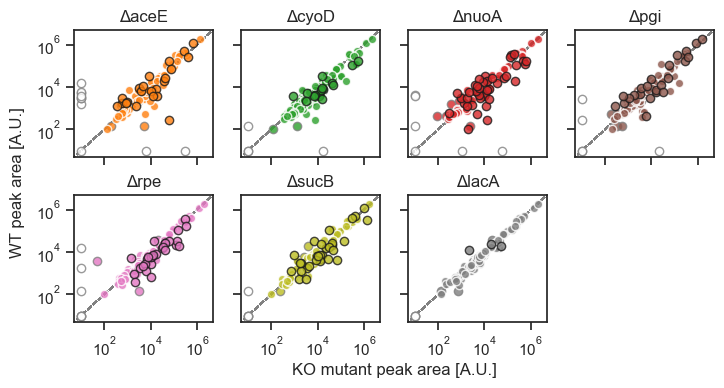

In [17]:
annotate = False
fig, axes = plt.subplots(2, 4, figsize=(8, 4), sharey=True, sharex = True)
axes = axes.flatten()
for i, strain in enumerate(exo_strains_x_wt):
    for j, m in enumerate(z_metabolites):
        ax = axes[i]
        ax.set_title(f'Δ{strain}')
        ax.set_xscale('log')
        ax.set_yscale('log')
        s_mean = counts_mean_std_dict[strain, m]['Mean']
        wt_mean = counts_mean_std_dict['WT', m]['Mean']

        if np.isnan(s_mean) or np.isnan(wt_mean):
            c = 'w'
            if np.isnan(s_mean):
                s_mean = 10
            if np.isnan(wt_mean):
                wt_mean = 10
        else:
            c = strain_colors[strain]

        try:
            pvalue = counts_adjusted_p_values_dict[strain, m]
        except:
            pvalue = np.nan
        
        if pvalue < 0.05:
            # print(f'{strain} {m} {pvalue:.2e}')
            mecolor = 'k'
            zorder = 100
        elif np.isnan(pvalue):
            mecolor = 'gray'
            zorder = 0
        else:
            mecolor = 'w'
            zorder = 10
        print(strain, m, c, s_mean, wt_mean, pvalue, mecolor)

        # mecolor = 'k'
        ax.errorbar(
            x=s_mean,
            y=wt_mean,
            # xerr=counts_mean_std_dict[strain, m]['Std'],
            # yerr=counts_mean_std_dict['WT', m]['Std'],
            fmt='o',
            # color='black',
            capsize=3,
            elinewidth=1,
            alpha=0.8,
            markeredgecolor=mecolor,
            # ecolor=mecolor,#wt_mets_colors[m],
            markerfacecolor = c,#'gray',
            zorder=zorder,
        )
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.plot([1e-2, 1e7], [1e-2, 1e7], ls = '--',c = 'gray', alpha=0.5, zorder=-10, lw = 1)

        # Annotate
        if annotate:
            if np.abs(np.log10(s_mean) - np.log10(wt_mean)) > 1:
                ax.annotate(
                    m,
                    xy=(counts_mean_std_dict[strain, m]['Mean'], counts_mean_std_dict['WT', m]['Mean']),
                    xytext=(counts_mean_std_dict[strain, m]['Mean']*1.5, counts_mean_std_dict['WT', m]['Mean']*1.5),
                    fontsize=8,
                    ha='center',
                    va='center',
                    # fontweight='bold',
                    color = 'k', #strain_colors[strain],
                )
        # ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(5, 5e6)
        ax.set_ylim(5, 5e6)
        # ax.set_ylim(-4, 4)
        # Increase the number of ticks on the x-axis
        ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=4))  # Major ticks
        ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=4))  # Major ticks
        # ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=6))  # Minor ticks

axes[-1].remove()
fig.supylabel('WT peak area [A.U.]', fontsize=12)
fig.supxlabel('KO mutant peak area [A.U.]', fontsize=12)
# plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.3, left = 0.1, bottom=0.15)
plt.savefig(figure_folder / 'KEIO_exometabolome_wt_comparison_v1_counts.pdf', bbox_inches='tight')

# Print statistics

In [18]:
# Print statistics
counts_diffs = []
for i, strain in enumerate(exo_strains_x_wt):
    for j, m in enumerate(z_metabolites):
        try:
            pvalue = counts_adjusted_p_values_dict[strain, m]
        except:
            pvalue = np.nan
        # pvalue = counts_adjusted_p_values_dict[strain, m]
        s_mean = counts_mean_std_dict[strain, m]['Mean']
        wt_mean = counts_mean_std_dict['WT', m]['Mean']
        s_std = counts_mean_std_dict[strain, m]['Std']
        wt_std = counts_mean_std_dict['WT', m]['Std']
        if np.isnan(wt_mean) and not np.isnan(s_mean*s_std):
            pvalue = 1e-10
        counts_diffs.append((strain, m, pvalue, s_mean, wt_mean, s_std, wt_std))
df_counts_diffs = pd.DataFrame(counts_diffs, columns=['Strain', 'Metabolite', 'adj. pvalue', 'Strain_mean', 'WT_mean', 'Strain_std', 'WT_std'])

In [19]:
uM_diffs = []
for i, strain in enumerate(exo_strains_x_wt):
    for j, m in enumerate(uM_metabolites):
        try:
            pvalue = adjusted_p_values_dict[strain, m]
        except:
            pvalue = np.nan
        # pvalue = counts_adjusted_p_values_dict[strain, m]
        s_mean = uM_mean_std_dict[strain, m]['Mean']
        wt_mean = uM_mean_std_dict['WT', m]['Mean']
        s_std = uM_mean_std_dict[strain, m]['Std']
        wt_std = uM_mean_std_dict['WT', m]['Std']
        if np.isnan(wt_mean) and not np.isnan(s_mean*s_std):
            pvalue = 1e-10
        uM_diffs.append((strain, m, pvalue, s_mean, wt_mean, s_std, wt_std))
df_uM_diffs = pd.DataFrame(uM_diffs, columns=['Strain', 'Metabolite', 'adj. pvalue', 'Strain_mean', 'WT_mean', 'Strain_std', 'WT_std'])

In [20]:
df_uM_diffs['WT ref'] = [x if not np.isnan(x) else 0 for x in df_uM_diffs['WT_mean'] ]

In [21]:
df_uM_diffs['Difference'] = df_uM_diffs['Strain_mean'] - df_uM_diffs['WT ref']

In [22]:

df_uM_diffs.sort_values('Difference', ascending=False).head(20)

Strain            Metabolite   adj. pvalue  Strain_mean    WT_mean  \
13    aceE               Lactate  1.183845e-01  5738.903655   2.261028   
51    nuoA               Lactate  2.755500e-02   387.567520   2.261028   
32    cyoD               Lactate  3.031223e-01   219.871394   2.261028   
64     pgi  Fructose-6-phosphate  3.354869e-02    78.869484   7.735606   
101   sucB               Citrate  1.126798e-03    43.715313  12.512888   
66     pgi   Glucose-6-phosphate  1.000000e-10    20.689664        NaN   
127   lacA               Lactate  3.135969e-01    13.692189   2.261028   
89     rpe               Lactate  7.219963e-02     9.687793   2.261028   
102   sucB  Fructose-6-phosphate  5.480013e-02    13.862113   7.735606   
83     rpe  Fructose-6-phosphate  1.052639e-01    13.261023   7.735606   
29    cyoD             Glutamate  3.024427e-01    12.537485   7.116785   
33    cyoD               Leucine  2.713135e-02     7.958294   3.131644   
6     aceE               Citrate  5.665054e-01    16.975133  12.512888   
82     rpe               Citrate  5.452998e-01    16.901643  12.512888   
86     rpe             Glutamate  4.372071e-02    11.343843   7.116785   
26    cyoD  Fructose-6-phosphate  1.539006e-01    11.924634   7.735606   
7     aceE  Fructose-6-phosphate  1.183845e-01    11.905702   7.735606   
108   sucB               Lactate  7.417486e-02     5.469575   2.261028   
52    nuoA               Leucine  2.755500e-02     6.191215   3.131644   
19    cyoD               Alanine  2.713135e-02     3.695558   1.264747   

      Strain_std    WT_std     WT ref   Difference  
13   2034.525794  0.943209   2.261028  5736.642627  
51     72.165452  0.943209   2.261028   385.306492  
32    255.302359  0.943209   2.261028   217.610365  
64     17.284474  1.317779   7.735606    71.133879  
101     2.552066  1.992018  12.512888    31.202425  
66      2.345093       NaN   0.000000    20.689664  
127     7.368799  0.943209   2.261028    11.431161  
89      3.554023  0.943209   2.261028     7.426764  
102     2.532979  1.317779   7.735606     6.126507  
83      3.478979  1.317779   7.735606     5.525417  
29      5.913161  0.771403   7.116785     5.420700  
33      0.777967  0.223656   3.131644     4.826650  
6       9.501841  1.992018  12.512888     4.462246  
82     10.469700  1.992018  12.512888     4.388755  
86      1.404124  0.771403   7.116785     4.227058  
26      2.920883  1.317779   7.735606     4.189029  
7       0.078163  1.317779   7.735606     4.170096  
108     1.650108  0.943209   2.261028     3.208547  
52      0.609509  0.223656   3.131644     3.059571  
19      0.460940  0.104665   1.264747     2.430810

In [23]:
p_values_dict['aceE', 'Lactate']

np.float64(0.03946148607440755)

In [24]:
# Get the top 5 significant metabolites (lowest adj. pvalue) for each strain
top5_metabolites = (
    df_uM_diffs
    .sort_values(['Strain', 'adj. pvalue'])
    .groupby('Strain')
    .head(5)
    .reset_index(drop=True)
)
display(top5_metabolites[['Strain', 'Metabolite', 'adj. pvalue']])# Get the top 5 significant metabolites (lowest adj. pvalue) for each strain


Strain            Metabolite   adj. pvalue
0    aceE                Valine  1.000000e-10
1    aceE  Fructose-6-phosphate  1.183845e-01
2    aceE   Gamma-aminobutyrate  1.183845e-01
3    aceE               Lactate  1.183845e-01
4    aceE               Leucine  1.474249e-01
5    cyoD             Glutamine  1.000000e-10
6    cyoD                Valine  1.000000e-10
7    cyoD                Malate  8.272377e-03
8    cyoD               Alanine  2.713135e-02
9    cyoD         Cis-aconitate  2.713135e-02
10   lacA    Alpha-aminoadipate  1.087066e-02
11   lacA               Leucine  1.420241e-01
12   lacA             Glutamate  1.556684e-01
13   lacA          Beta-alanine  3.135969e-01
14   lacA               Lactate  3.135969e-01
15   nuoA                Valine  1.000000e-10
16   nuoA               Alanine  3.716073e-03
17   nuoA         Cis-aconitate  2.755500e-02
18   nuoA             Glutamate  2.755500e-02
19   nuoA               Lactate  2.755500e-02
20    pgi            Asparagine  1.000000e-10
21    pgi   Glucose-6-phosphate  1.000000e-10
22    pgi             Glutamine  1.000000e-10
23    pgi         Cis-aconitate  8.734342e-03
24    pgi               Leucine  8.734342e-03
25    rpe             Glutamine  1.000000e-10
26    rpe          Beta-alanine  1.947644e-02
27    rpe               Leucine  2.085532e-02
28    rpe         Cis-aconitate  2.527784e-02
29    rpe                Malate  3.669586e-02
30   sucB            Asparagine  1.000000e-10
31   sucB             Glutamine  1.000000e-10
32   sucB             Aspartate  1.126798e-03
33   sucB               Citrate  1.126798e-03
34   sucB         Cis-aconitate  3.358801e-03

In [25]:
# Get the top 5 significant metabolites (lowest adj. pvalue) for each strain
top5_metabolites = (
    df_counts_diffs
    .sort_values(['Strain', 'adj. pvalue'])
    .groupby('Strain')
    .head(5)
    .reset_index(drop=True)
)
display(top5_metabolites[['Strain', 'Metabolite', 'adj. pvalue']])# Get the top 5 significant metabolites (lowest adj. pvalue) for each strain


Strain                   Metabolite   adj. pvalue
0    aceE  2-oxobutanoate/acetoacetate  1.000000e-10
1    aceE                     Pyruvate  1.000000e-10
2    aceE            3-hydroxybutyrate  2.621170e-04
3    aceE                         cAMP  1.391094e-03
4    aceE                 Ethanolamine  2.162208e-02
5    cyoD                   Oxoproline  1.396029e-02
6    cyoD       2-hydroxyglutaric acid  2.759011e-02
7    cyoD       3-hydroxyglutaric acid  2.759011e-02
8    cyoD                    Adenosine  2.759011e-02
9    cyoD                       Malate  2.759011e-02
10   lacA                   Riboflavin  1.359294e-02
11   lacA                       Uracil  1.359294e-02
12   lacA                   Putrescine  3.790795e-02
13   lacA                    Glutamate  9.518596e-02
14   lacA                      Leucine  9.518596e-02
15   nuoA  2-oxobutanoate/acetoacetate  1.000000e-10
16   nuoA                     Pyruvate  1.000000e-10
17   nuoA          Methylthioadenosine  3.414547e-04
18   nuoA                      Thymine  3.414547e-04
19   nuoA                         cAMP  3.414547e-04
20    pgi          Glucose-6-phosphate  1.000000e-10
21    pgi                   Nicotinate  4.785513e-03
22    pgi                         cAMP  6.957372e-03
23    pgi                    Succinate  9.922704e-03
24    pgi                       Uracil  9.922704e-03
25    rpe       2, 5-dihydroxybenzoate  2.914250e-03
26    rpe                 Hypoxanthine  2.914250e-03
27    rpe                   Salicylate  2.914250e-03
28    rpe           Guanidinosuccinate  1.292930e-02
29    rpe                   Nicotinate  1.292930e-02
30   sucB                   Riboflavin  2.617364e-03
31   sucB              Methylguanidine  4.237463e-03
32   sucB               N-acetylserine  4.237463e-03
33   sucB            3-hydroxybutyrate  4.850593e-03
34   sucB                Cis-aconitate  9.424556e-03

In [26]:
# Calculate the fraction of significant metabolites for each strain
significance_threshold = 0.05
fraction_significant = (
    df_counts_diffs
    .groupby('Strain')
    .apply(lambda df: (df['adj. pvalue'] < significance_threshold).mean())
    .rename('Fraction_significant')
    .reset_index()
)
display(fraction_significant)

# Calculate the fraction of significant metabolites for each strain
significance_threshold = 0.05
N_significant = (
    df_counts_diffs
    .groupby('Strain')
    .apply(lambda df: (df['adj. pvalue'] < significance_threshold).sum())
    .rename('N_significant')
    .reset_index()
)
display(N_significant)
print(df_counts_diffs.Metabolite.nunique())

/var/folders/xf/kl76knj11y72v0_qy4vv7tgh0000gp/T/ipykernel_65435/879466117.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: (df['adj. pvalue'] < significance_threshold).mean())


Strain  Fraction_significant
0   aceE              0.216216
1   cyoD              0.144144
2   lacA              0.027027
3   nuoA              0.378378
4    pgi              0.216216
5    rpe              0.252252
6   sucB              0.279279

/var/folders/xf/kl76knj11y72v0_qy4vv7tgh0000gp/T/ipykernel_65435/879466117.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: (df['adj. pvalue'] < significance_threshold).sum())


Strain  N_significant
0   aceE             24
1   cyoD             16
2   lacA              3
3   nuoA             42
4    pgi             24
5    rpe             28
6   sucB             31

111


In [27]:
22/111


0.1981981981981982

In [28]:
df_log_diffs = pd.Series(log_diffs).reset_index()
df_log_diffs.columns = ['Strain', 'Metabolite', 'LogDiff']

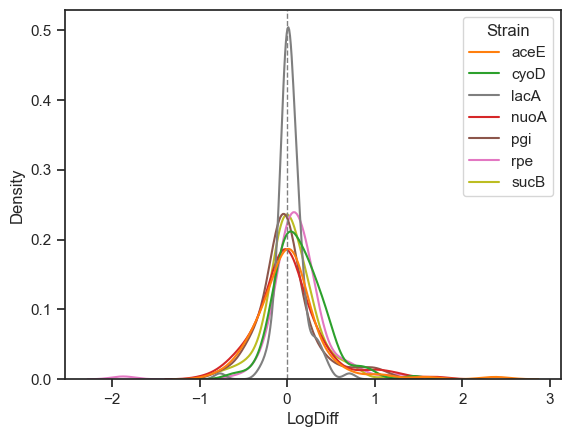

In [29]:
# log_diff = 
ax = sns.kdeplot(data = df_log_diffs, x = 'LogDiff', hue = 'Strain', palette=strain_colors)
ax.axvline(0, ls = '--', c = 'gray', lw = 1)


In [30]:
df_log_diffs.dropna(inplace=True)

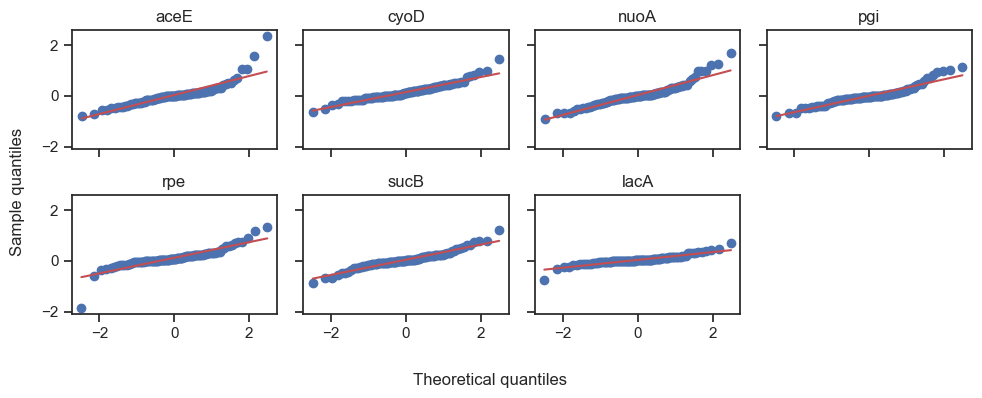

In [31]:
fig, axes = plt.subplots(2, 4, figsize=(10, 4), sharex=True, sharey=True)
axes = axes.flatten()
for i, strain in enumerate(exo_strains_x_wt):
    ax = axes[i]
    df_log_diffs_s = df_log_diffs.loc[df_log_diffs.Strain == strain]
    # print(df_log_diffs_s)
    # print(st.probplot(df_log_diffs_s.LogDiff, dist="norm", plot=plt, ))
    st.probplot(df_log_diffs_s.LogDiff, dist="norm", plot=ax, fit = True)#, rvalue=True)
    ax.set_title(strain)
    ax.set_xlabel('')
    ax.set_ylabel('')
    # ax.set_xlim(-3, 3)
    # ax.set_ylim(-3, 3)
fig.supxlabel('Theoretical quantiles', fontsize=12)
fig.supylabel('Sample quantiles', fontsize=12)
axes[-1].remove()
plt.tight_layout()
# st.probplot(df_log_diffs.LogDiff, dist="norm", plot=plt, )

In [32]:

wt_mets = sorted(df_uM.loc[df_uM.Strain == 'WT', df_uM.loc[df_uM.Strain == 'WT'].notna().any()].columns[1:-4])

In [33]:
mets_cmap = plt.get_cmap('tab20', len(wt_mets))
wt_mets_colors = {m: mets_cmap(i) for i, m in enumerate(wt_mets)}

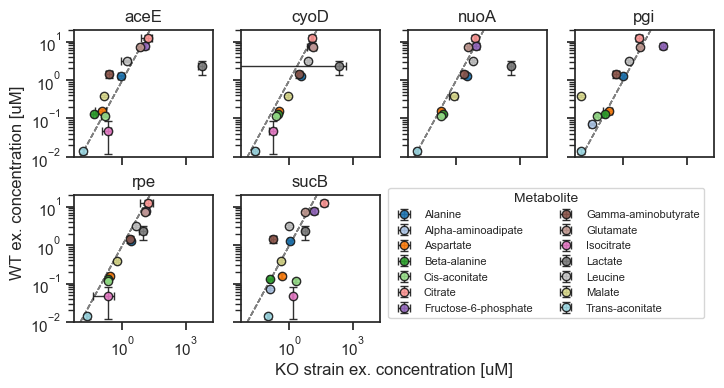

In [34]:
from matplotlib.ticker import LogLocator, NullFormatter

fig, axes = plt.subplots(2, 4, figsize=(8, 4), sharey=True, sharex = True)
axes = axes.flatten()
for i, strain in enumerate(exo_strains_x_wt):
    if strain == 'lacA':
        continue
    for j, m in enumerate(uM_metabolites):
        ax = axes[i]
        ax.set_title(strain)
        ax.set_xscale('log')
        ax.set_yscale('log')
        x_mean = uM_mean_std_dict[strain, m]['Mean']
        y_mean = uM_mean_std_dict['WT', m]['Mean']
        if np.isnan(x_mean) or np.isnan(y_mean):
            continue
        ax.errorbar(
            x=x_mean,
            y=y_mean,
            xerr=uM_mean_std_dict[strain, m]['Std'],
            yerr=uM_mean_std_dict['WT', m]['Std'],
            fmt='o',
            # color='black',
            capsize=3,
            elinewidth=1,
            alpha=0.9,
            markeredgecolor='k',
            ecolor='k',#wt_mets_colors[m],
            c = wt_mets_colors[m],
            label = m,
        )
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.plot([1e-2, 1e3], [1e-2, 1e3], ls = '--',c = 'gray', alpha=0.5, zorder=-10, lw = 1)

        # ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(5e-3, 2e4)
        ax.set_ylim(1e-2, 2e1)
        # ax.set_ylim(-4, 4)
        # Increase the number of ticks on the x-axis
        ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=4))  # Major ticks
        # ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=6))  # Minor ticks

axes[-3].legend(
    loc='upper left',
    bbox_to_anchor=(1.02, 1.1),
    fontsize=8,
    title='Metabolite',
    title_fontsize='10',
    frameon=True,
    ncol=2,
)
axes[-1].remove()
axes[-2].remove()

fig.supylabel('WT ex. concentration [uM]', fontsize=12)
fig.supxlabel('KO strain ex. concentration [uM]', fontsize=12)
# plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.3, left = 0.1, bottom=0.15)
plt.savefig(figure_folder / 'KEIO_exometabolome_wt_comparison_v2.pdf', bbox_inches='tight')

## PCA of z_score


In [35]:
X_df = df_z_scores_samples[z_metabolites].copy()

In [36]:
X_df = X_df.apply(lambda col: col.fillna(col.min()), axis = 0)

In [37]:
X = StandardScaler().fit_transform(X_df)

pca = PCA(n_components=2)
Xn = pca.fit_transform(X)
pca_df = pd.DataFrame(
    data = Xn,
    columns = ['PC1', 'PC2'],
    index = df_z_scores_samples.Sample_id,
)
pca_df['Strain'] = df_z_scores_samples.Strain.values


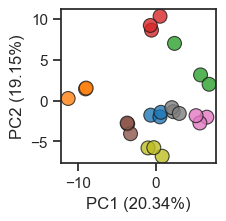

In [38]:
fig, ax = plt.subplots(figsize=(2, 2))
pca_df.sort_values(by = 'Strain', inplace=True)
sns.scatterplot(
    data = pca_df,
    x = 'PC1',
    y = 'PC2',
    hue = 'Strain',
    palette = strain_colors,
    alpha = 0.8,
    edgecolor = 'k',
    s = 100,
    ax=ax,
    legend=False,
    )
ax.set_xlabel('PC1 (%.2f%%)' % (pca.explained_variance_ratio_[0] * 100))
ax.set_ylabel('PC2 (%.2f%%)' % (pca.explained_variance_ratio_[1] * 100))
# sns.despine()
plt.savefig(figure_folder / 'KEIO_exometabolome_pca.pdf', bbox_inches='tight')

# Plot growth curves and yield from tubes

In [39]:
df_od_tubes = pd.read_csv(fn_tubes, index_col=0)
df_od_tubes.rename(columns={'Hours': 'Time [h]'}, inplace=True) 

# only keep data fro strains we did exomtabolome on
df_od_tubes = df_od_tubes.loc[df_od_tubes.Strain.isin(exo_strains)]

# strains = sorted(df_od_tubes.Strain.unique())
replicates = ['A', 'B', 'C']

yield_df = df_od_tubes.groupby(['Strain', 'Replicate']).agg({'OD600': 'max'}).reset_index()

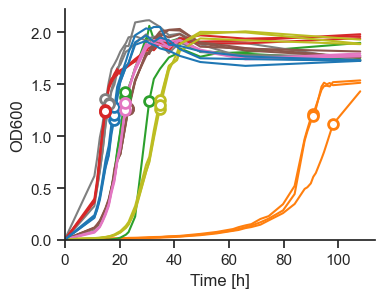

In [40]:
fig, ax = plt.subplots(figsize=(4, 3))
ax = sns.lineplot(data = df_od_tubes, x = 'Time [h]', y = 'OD600', hue = 'Strain',# style = 'Replicate',
                   palette = strain_colors, markers=True, units='Replicate', estimator=None, legend=False)# marker = 'o')
# sns.move_legend(ax, loc = 'upper left', bbox_to_anchor=(1, 1), title = 'Strain', fontsize = 10)
for strain in exo_strains:
    for replicate in replicates:
        idx = (df_uM.Strain == strain) & ( df_uM.Replicate == replicate)
        time = df_uM.loc[idx, 'Hours'].values[0]
        od = df_uM.loc[idx, 'OD'].values[0]
        ax.scatter(
            x = time,
            y = od,
            color = 'w',
            marker = 'o',
            s = 50,
            edgecolor = strain_colors[strain],
            linewidth = 2,
            zorder = 100

            # label = f'{strain} {replicate}',
        )

# plt.yscale('log')
sns.despine()
ax.set_ylim(0)
ax.set_xlim(0)
plt.savefig(figure_folder / '2A_screening_tubes_OD.pdf', bbox_inches='tight')

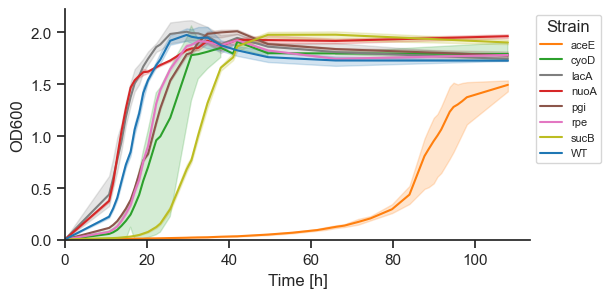

In [41]:
fig, ax = plt.subplots(figsize=(6, 3))
ax = sns.lineplot(data = df_od_tubes, x = 'Time [h]', y = 'OD600', hue = 'Strain', 
                  palette = strain_colors)
sns.move_legend(ax, loc = 'upper left', bbox_to_anchor=(1, 1), title = 'Strain', fontsize = 8)
sns.despine()
ax.set_ylim(0)
ax.set_xlim(0)
plt.savefig(figure_folder / '2A_screening_tubes_OD_error_band.pdf', bbox_inches='tight')

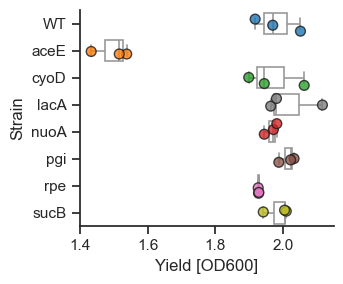

In [42]:

g = sns.catplot(data = yield_df, y = 'Strain', x = 'OD600',hue = 'Strain', 
                aspect=1.2, s = 50, height=3, alpha = 0.8, jitter = 0.3, edgecolor='k',
                  linewidth = 1, palette=strain_colors, order=exo_strains)
g.map_dataframe(sns.boxplot, y = 'Strain', x = 'OD600', color = 'w', fliersize = 0, linewidth = 1.2)
g.set_axis_labels('Yield [OD600]', 'Strain')
plt.savefig(figure_folder / 'strain_yield.pdf', bbox_inches='tight')

### Get growth rates

In [43]:
df_od_tubes

Sample ID Strain  Time [h]  OD600 Replicate
0           1A   aceE       0.0  0.008         A
1           1B   aceE       0.0  0.003         B
2           1C   aceE       0.0  0.007         C
3           2A   cyoD       0.0  0.009         A
4           2B   cyoD       0.0  0.006         B
...        ...    ...       ...    ...       ...
1375        8B   sucB     108.0  1.891         B
1376        8C   sucB     108.0  1.887         C
1383       11A     WT     108.0  1.726         A
1384       11B     WT     108.0  1.727         B
1385       11C     WT     108.0  1.732         C

[1008 rows x 5 columns]

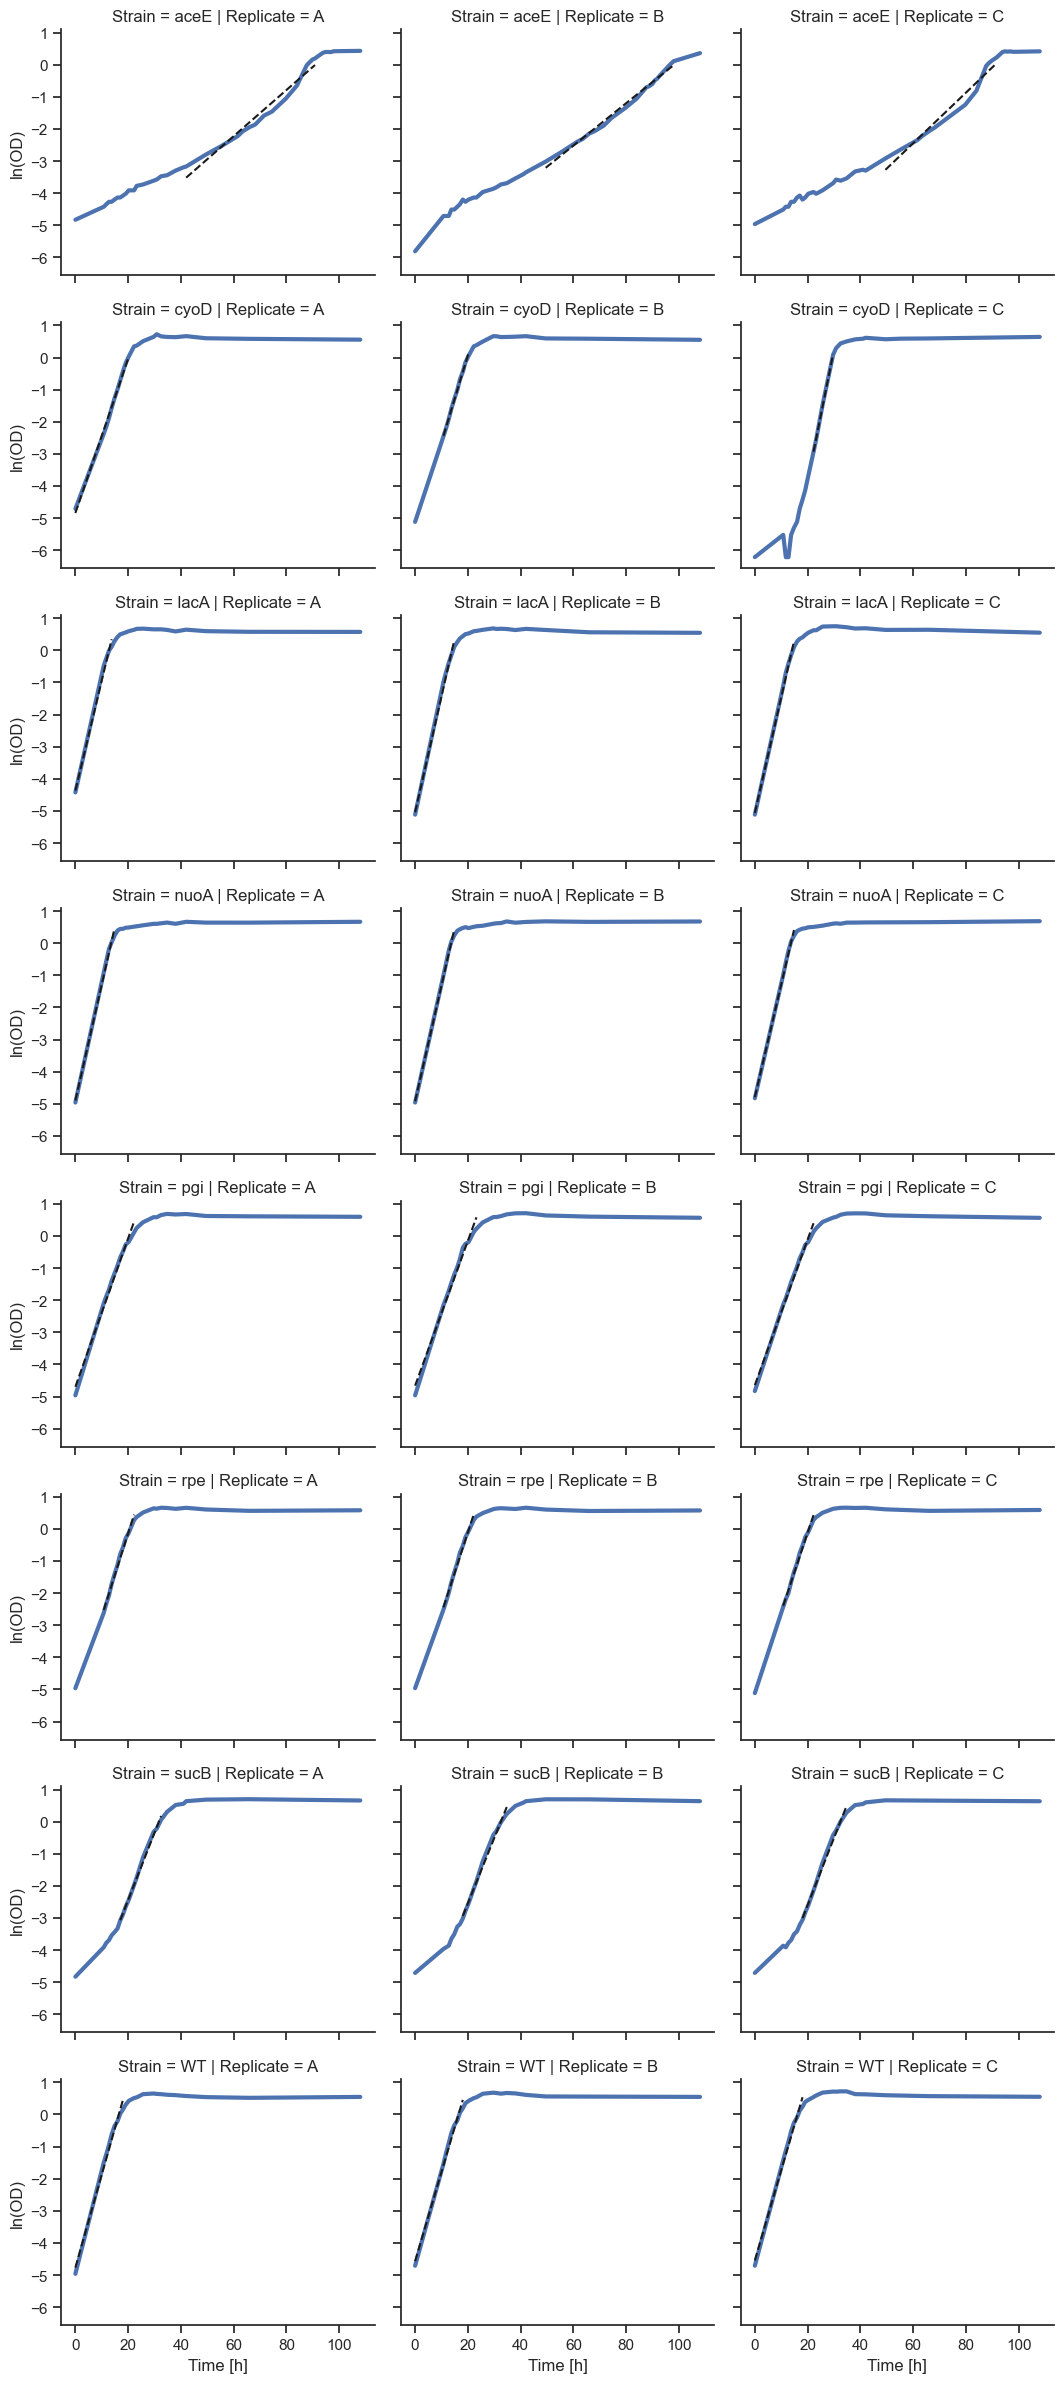

In [44]:
df_od_tubes['ln(OD)'] = np.log([x for x in df_od_tubes['OD600']])
g = sns.relplot(data=df_od_tubes, x = 'Time [h]', y = 'ln(OD)', row = 'Strain', col = 'Replicate', kind = 'line', lw = 3, height = 3, aspect = 1.2)
data = []
od_range = [0.05, 1.2]
for sample_id in df_od_tubes['Sample ID'].unique():
    idx = (df_od_tubes['Sample ID']==sample_id)
    dfi = df_od_tubes.loc[idx]
    strain = dfi.Strain.iloc[0]
    rep = sample_id[-1]
    ax = g.axes_dict[(strain, rep)]
    
    idx0 = (dfi['OD600']-od_range[0]).abs().argmin()
    idx1 = (dfi['OD600']-od_range[1]).abs().argmin()
    
    ln_OD = dfi.iloc[idx0:idx1+1]['ln(OD)']
    hours = dfi.iloc[idx0:idx1+1]['Time [h]']
    fit = np.polyfit(hours, ln_OD, 1)
    x_arr = np.linspace(hours.min(), hours.max(), 2)
    y_arr = x_arr*fit[0]+fit[1]
    # delta_ln_OD = - dfi.iloc[idx0]['ln(OD)']
    # delta_t = dfi.Hours.iloc[idx1]-dfi.Hours.iloc[idx0]
    # growth_rate = delta_ln_OD/delta_t
    growth_rate = fit[0]
    data.append([strain, rep, growth_rate])

    # Plot
    # ax.plot([dfi.Hours.iloc[idx0], dfi.Hours.iloc[idx1]], [dfi.iloc[idx0]['ln(OD)'], dfi.iloc[idx1]['ln(OD)']], c = 'k', ls = '--')
    ax.plot(x_arr, y_arr, c = 'k', ls = '--')
    
df_tube_rate = pd.DataFrame(data, columns = ['Strain', 'Replicate', 'Growth rate'])       

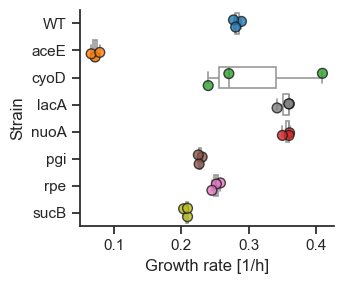

In [45]:



g = sns.catplot(df_tube_rate, x = 'Growth rate', y = 'Strain', hue = 'Strain', order = exo_strains, palette=strain_colors,
                aspect=1.2, s = 50, height=3, alpha = 0.8, jitter = 0.3, edgecolor='k',
                  linewidth = 1)
g.map_dataframe(sns.boxplot, y = 'Strain', x = 'Growth rate', color = 'w', fliersize = 0, linewidth = 1.2)
g.set_axis_labels('Growth rate [1/h]', 'Strain')
plt.savefig(figure_folder / 'strain_rate.pdf', bbox_inches='tight')

# Plot metabolomics data

In [46]:
# Make long data frame
dfL_counts = pd.melt(df_counts_samples.reset_index(), id_vars=['Strain', 'Sample_id'], var_name='Metabolite', value_name='Counts', value_vars=z_metabolites)
dfL_uM = pd.melt(df_uMsamples.reset_index(), id_vars=['Strain', 'Sample_id'], var_name='Metabolite', value_name='Concentration [uM]', value_vars=uM_metabolites)

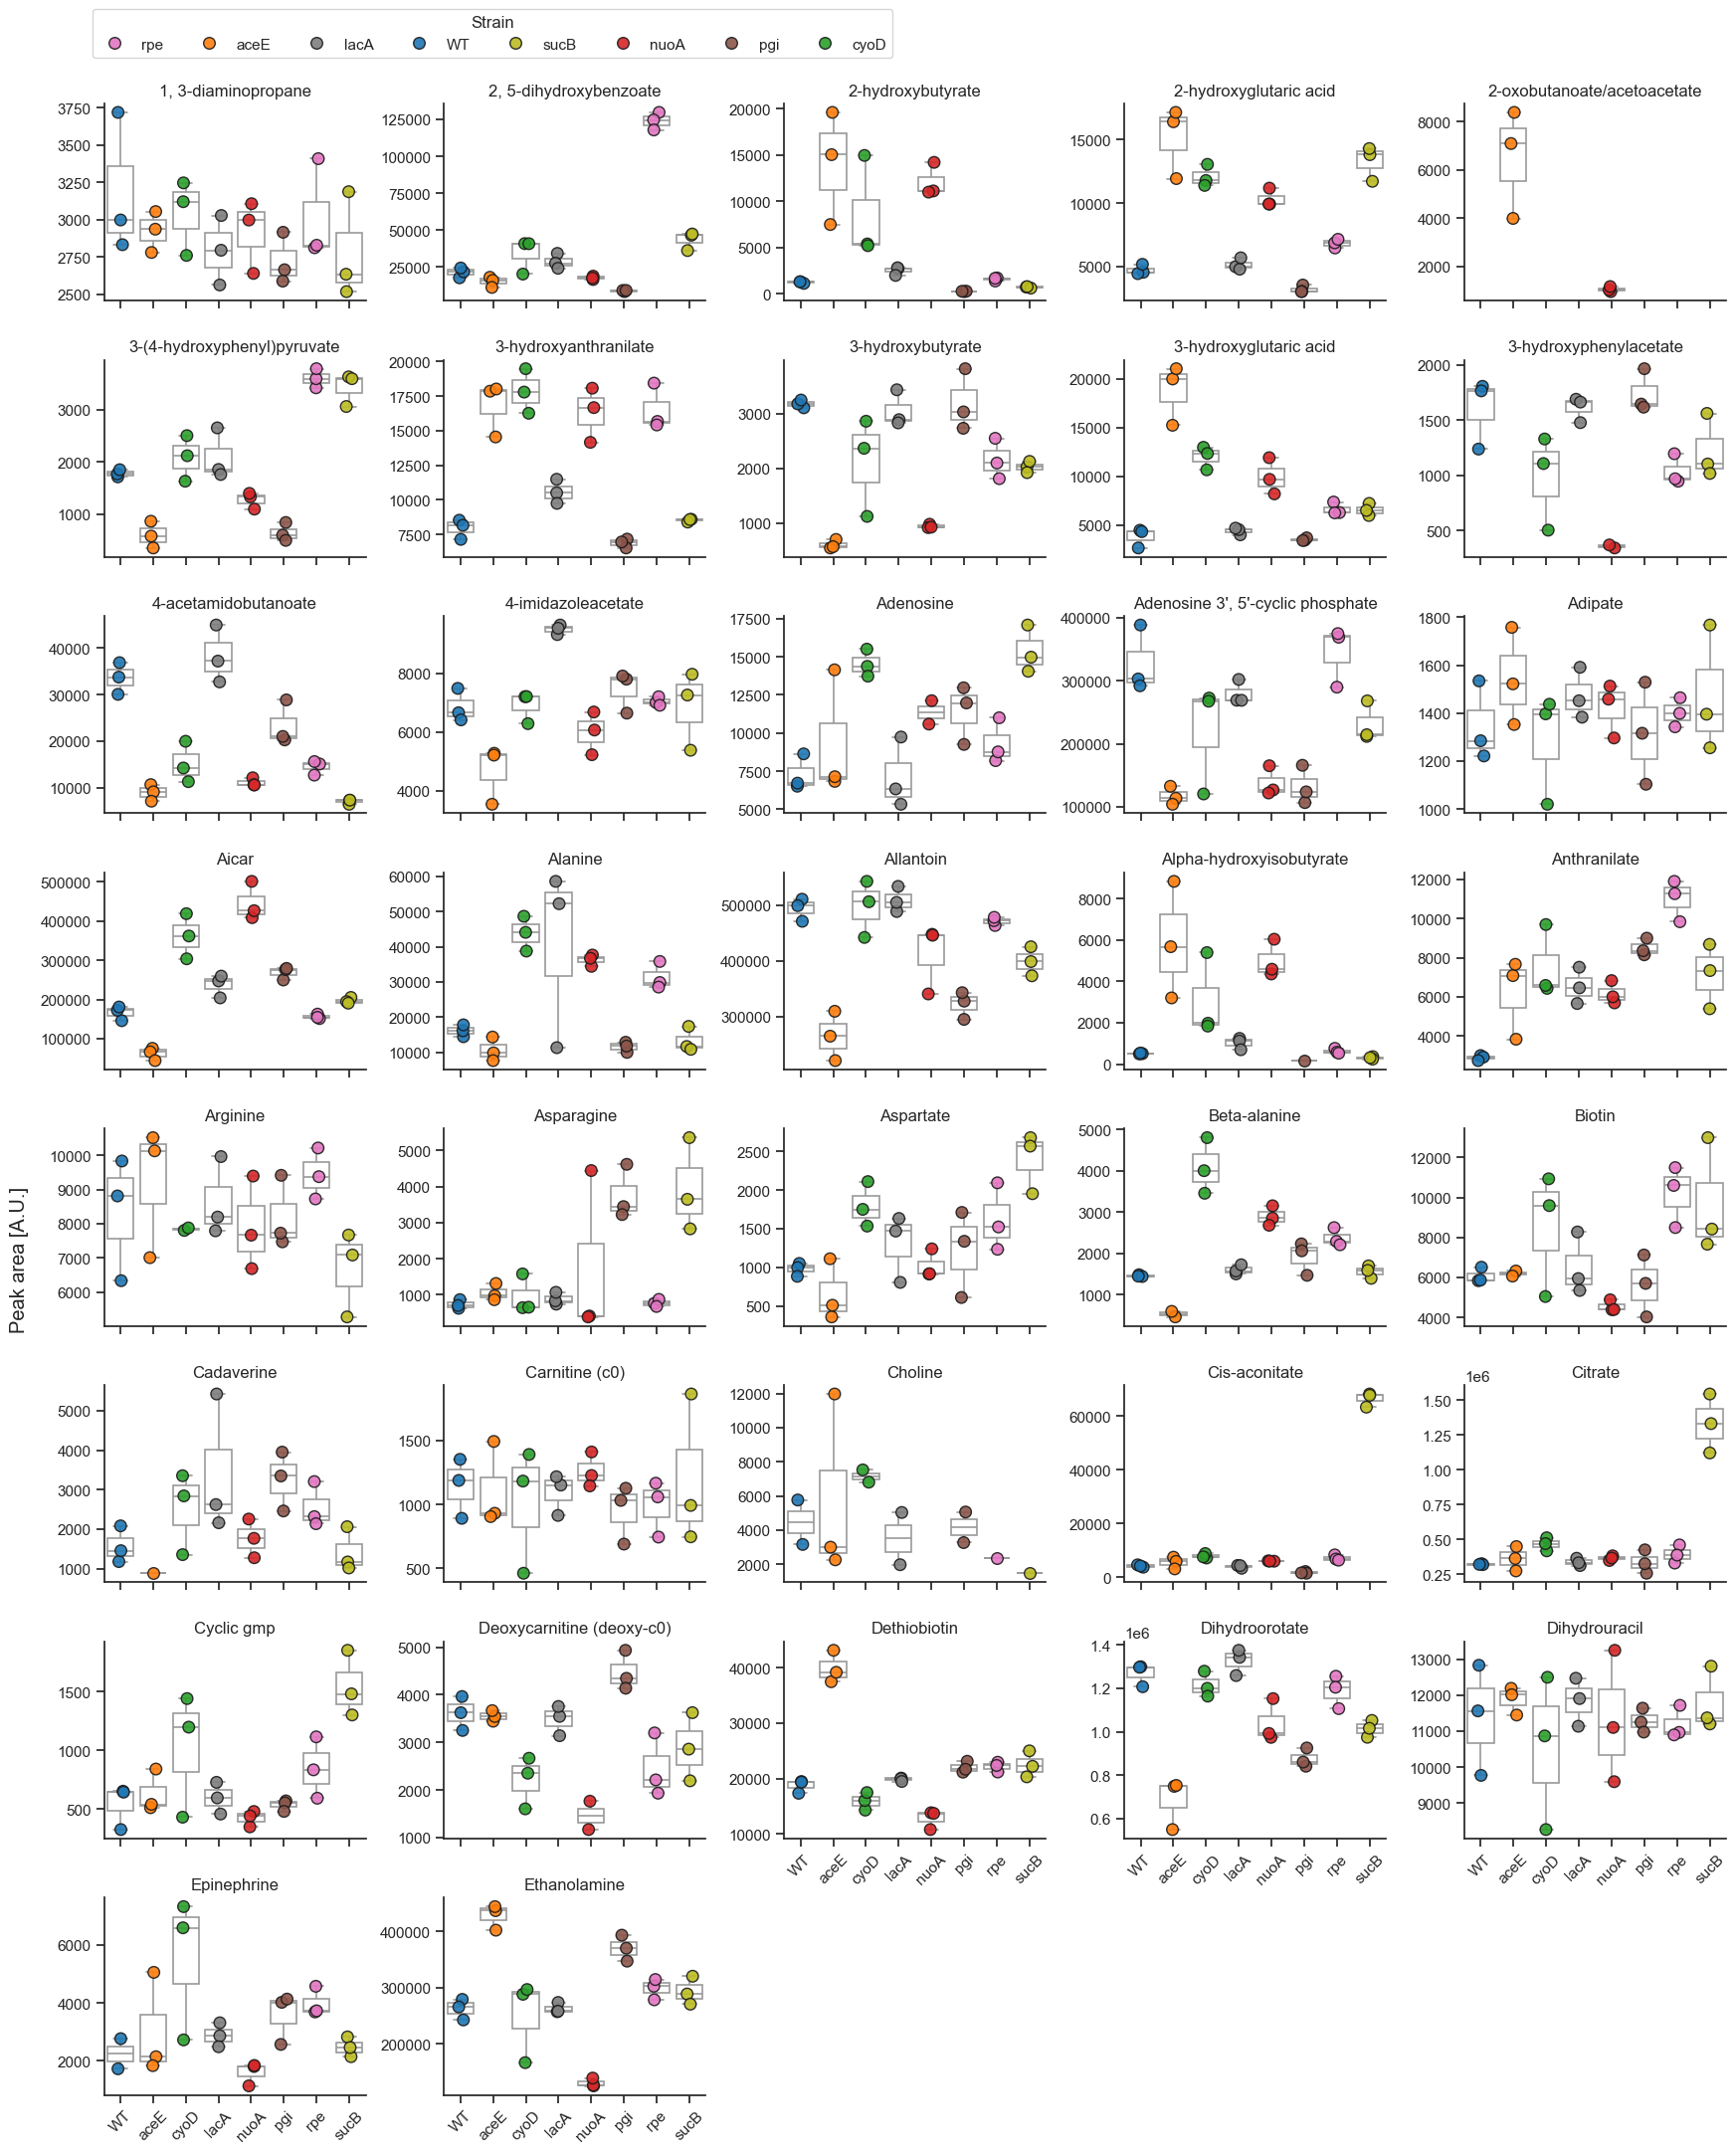

In [47]:
# sns.set_theme(font_scale=1.2, style='ticks')
n3 = int(len(z_metabolites)/3)
first = z_metabolites[:n3]
second = z_metabolites[n3:2*n3]
third = z_metabolites[2*n3:]
idx1 = dfL_counts.Metabolite.isin(first)
g = sns.catplot(data = dfL_counts.loc[idx1], x = 'Strain', y = 'Counts', hue = 'Strain', order = exo_strains, palette=strain_colors,
            col = 'Metabolite',col_wrap=5, sharey=False, s = 70, alpha = 0.9, linewidth = 1, edgecolor='k',height=3, aspect=1.2,legend = True)
g.map_dataframe(sns.boxplot, x = 'Strain', y = 'Counts',color = 'w', fliersize = 0, linewidth = 1.2)
g.set_titles(col_template="{col_name}")
# Rotate x-tick labels for all axes
for ax in g.axes.flat:
    # if (ax.get_ylim()[1]/ax.get_ylim()[0] > 10) or ((ax.get_ylim()[0] <=0) and (ax.get_ylim()[1] > 100)):
    # ax.set_yscale('log')
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('center')
sns.move_legend(g, loc = 'lower left', bbox_to_anchor = (0.06,1), ncol = 8, frameon = True)
g.set_axis_labels('', '')
g.fig.supylabel('Peak area [A.U.]')
plt.subplots_adjust(wspace=0.3, hspace=0.3, left = 0.07, bottom=0.15)
plt.savefig(figure_folder / 'KEIO_KO_exometabolome_counts_1.pdf', bbox_inches='tight')
plt.savefig(figure_folder / 'KEIO_KO_exometabolome_counts_1.png', bbox_inches='tight', dpi = 300)

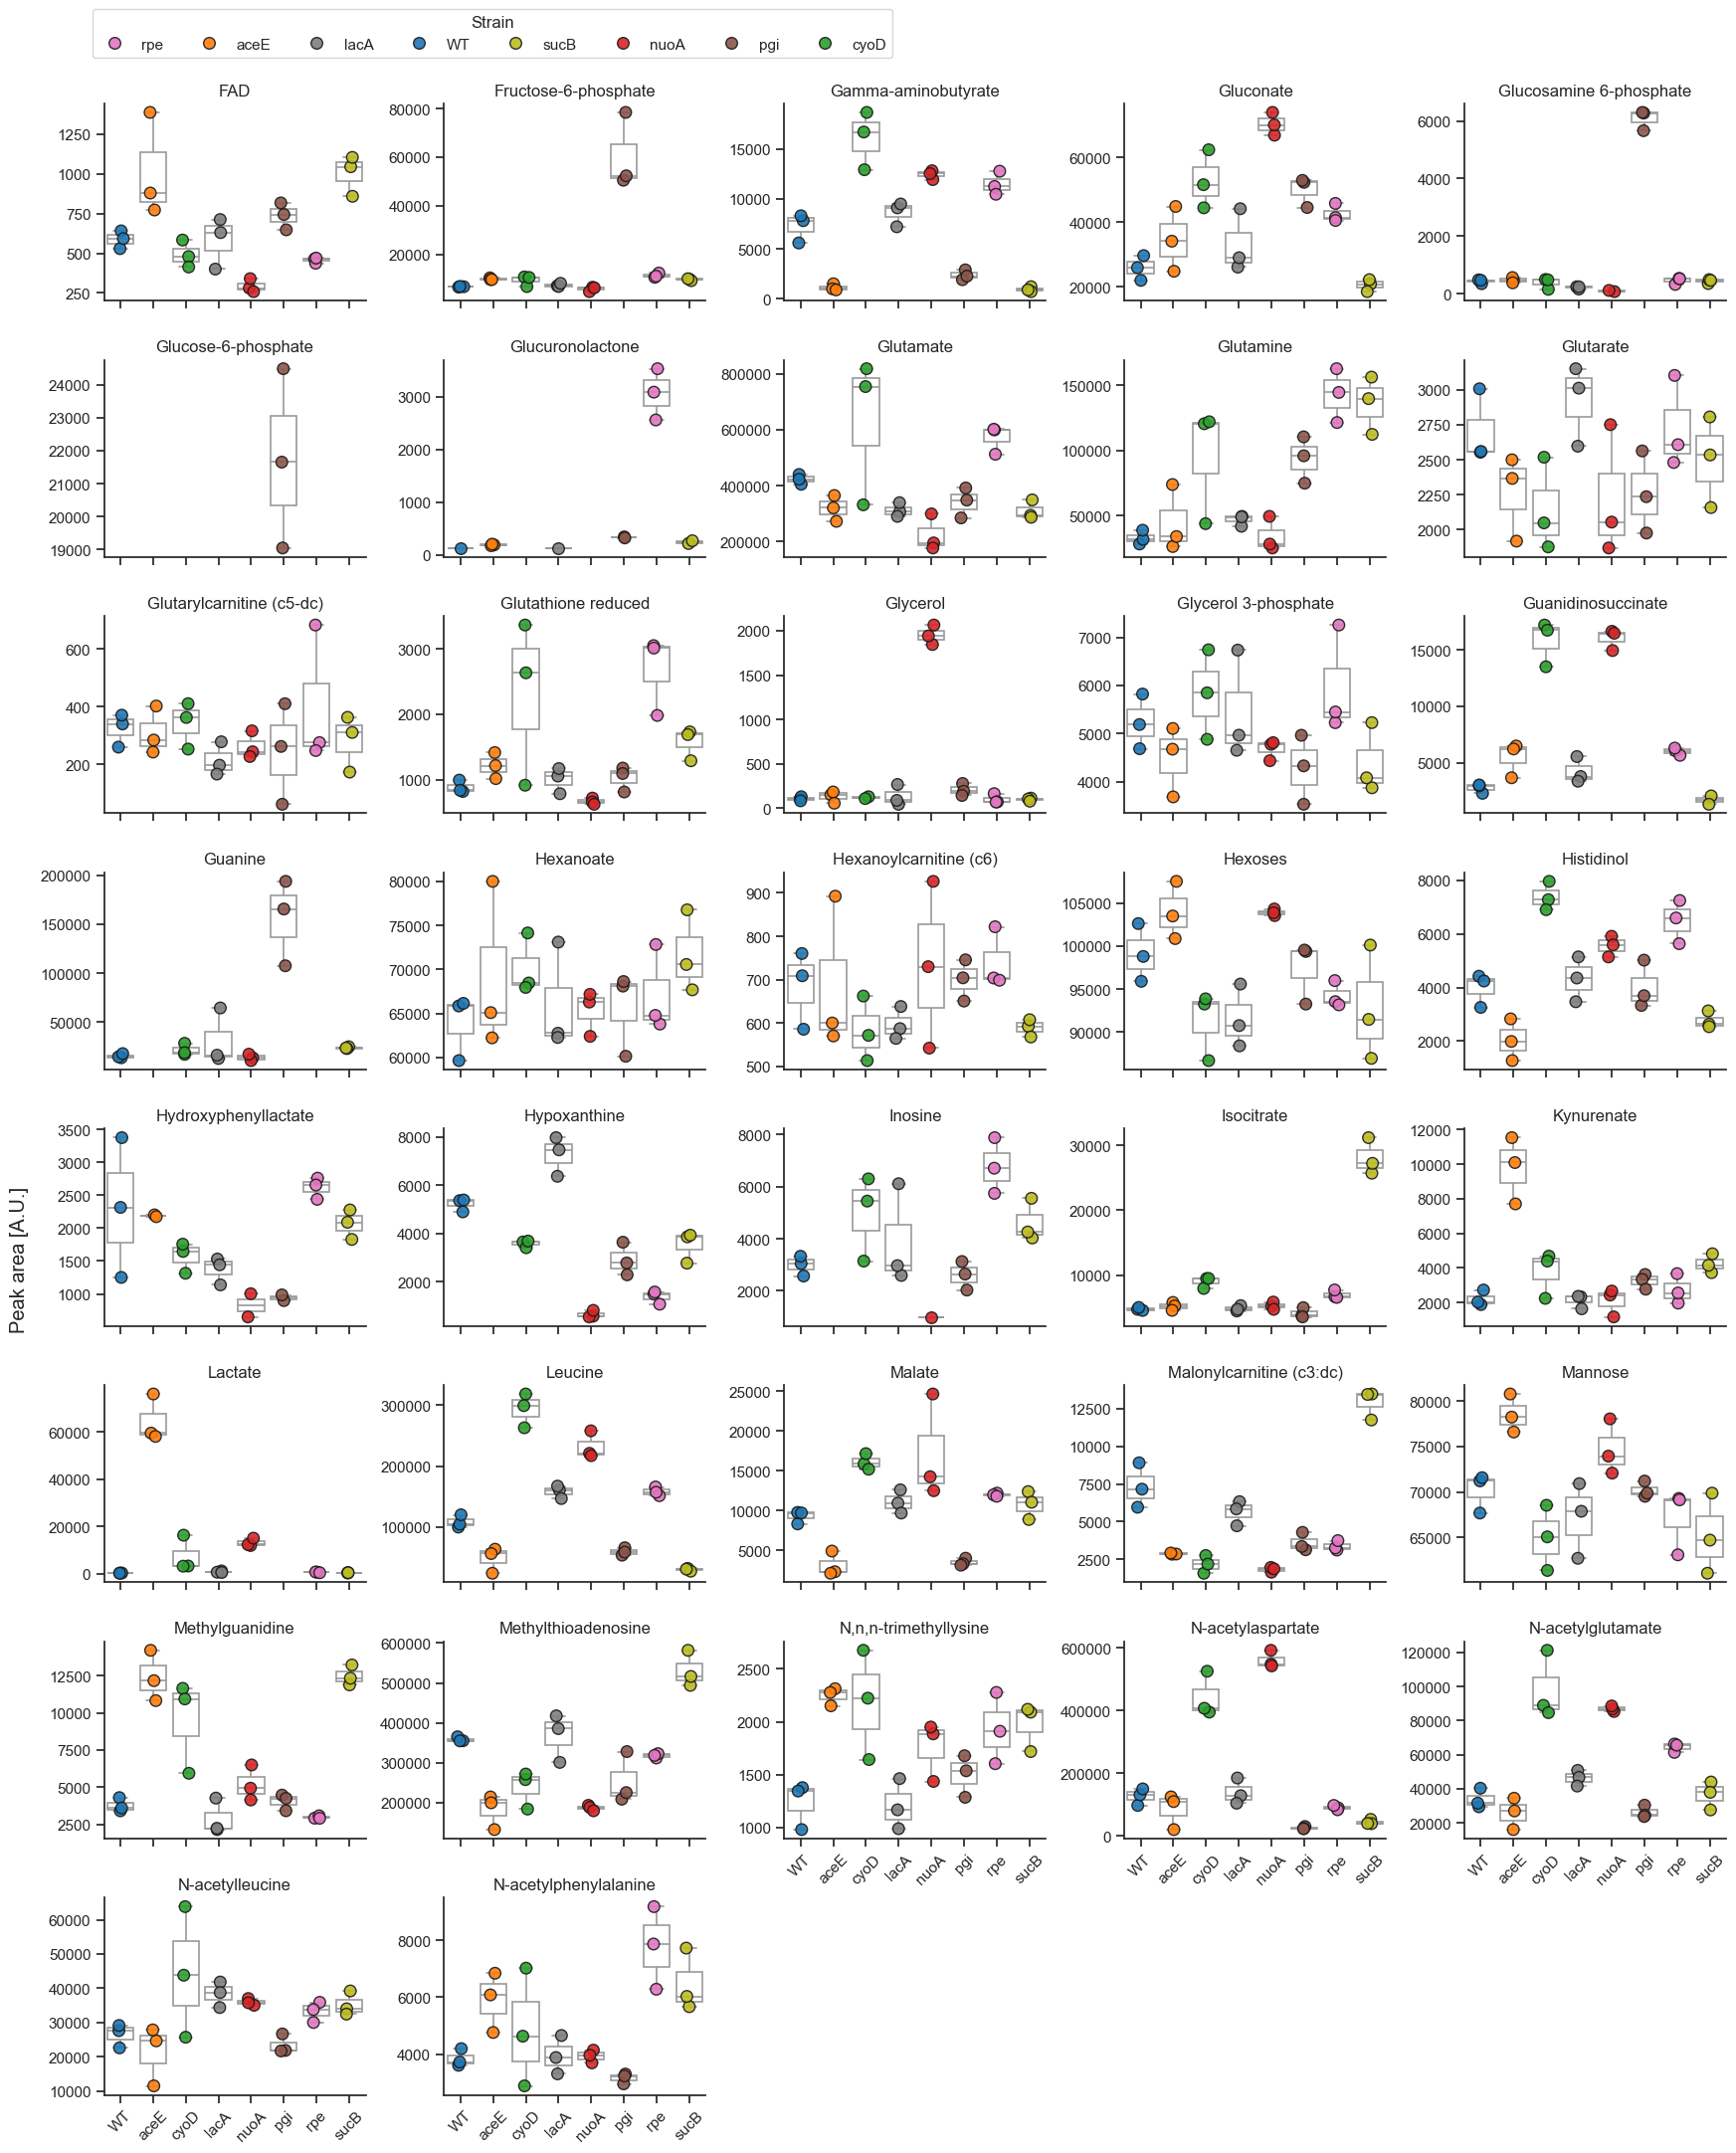

In [48]:
# sns.set_theme(font_scale=1.2, style='ticks')
idx2 = dfL_counts.Metabolite.isin(second)

g = sns.catplot(data = dfL_counts.loc[idx2], x = 'Strain', y = 'Counts', hue = 'Strain', order = exo_strains, palette=strain_colors,
            col = 'Metabolite',col_wrap=5, sharey=False, s = 70, alpha = 0.9, linewidth = 1, edgecolor='k',height=3, aspect=1.2,legend = True)
g.map_dataframe(sns.boxplot, x = 'Strain', y = 'Counts',color = 'w', fliersize = 0, linewidth = 1.2)
g.set_titles(col_template="{col_name}")
# Rotate x-tick labels for all axes
for ax in g.axes.flat:
    # if (ax.get_ylim()[1]/ax.get_ylim()[0] > 10) or ((ax.get_ylim()[0] <=0) and (ax.get_ylim()[1] > 100)):
    # ax.set_yscale('log')
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('center')
sns.move_legend(g, loc = 'lower left', bbox_to_anchor = (0.06,1), ncol = 8, frameon = True)

g.set_axis_labels('', '')
g.fig.supylabel('Peak area [A.U.]')
plt.subplots_adjust(wspace=0.3, hspace=0.3, left = 0.07, bottom=0.15)
plt.savefig(figure_folder / 'KEIO_KO_exometabolome_counts_2.pdf', bbox_inches='tight')
plt.savefig(figure_folder / 'KEIO_KO_exometabolome_counts_2.png', bbox_inches='tight', dpi = 300)

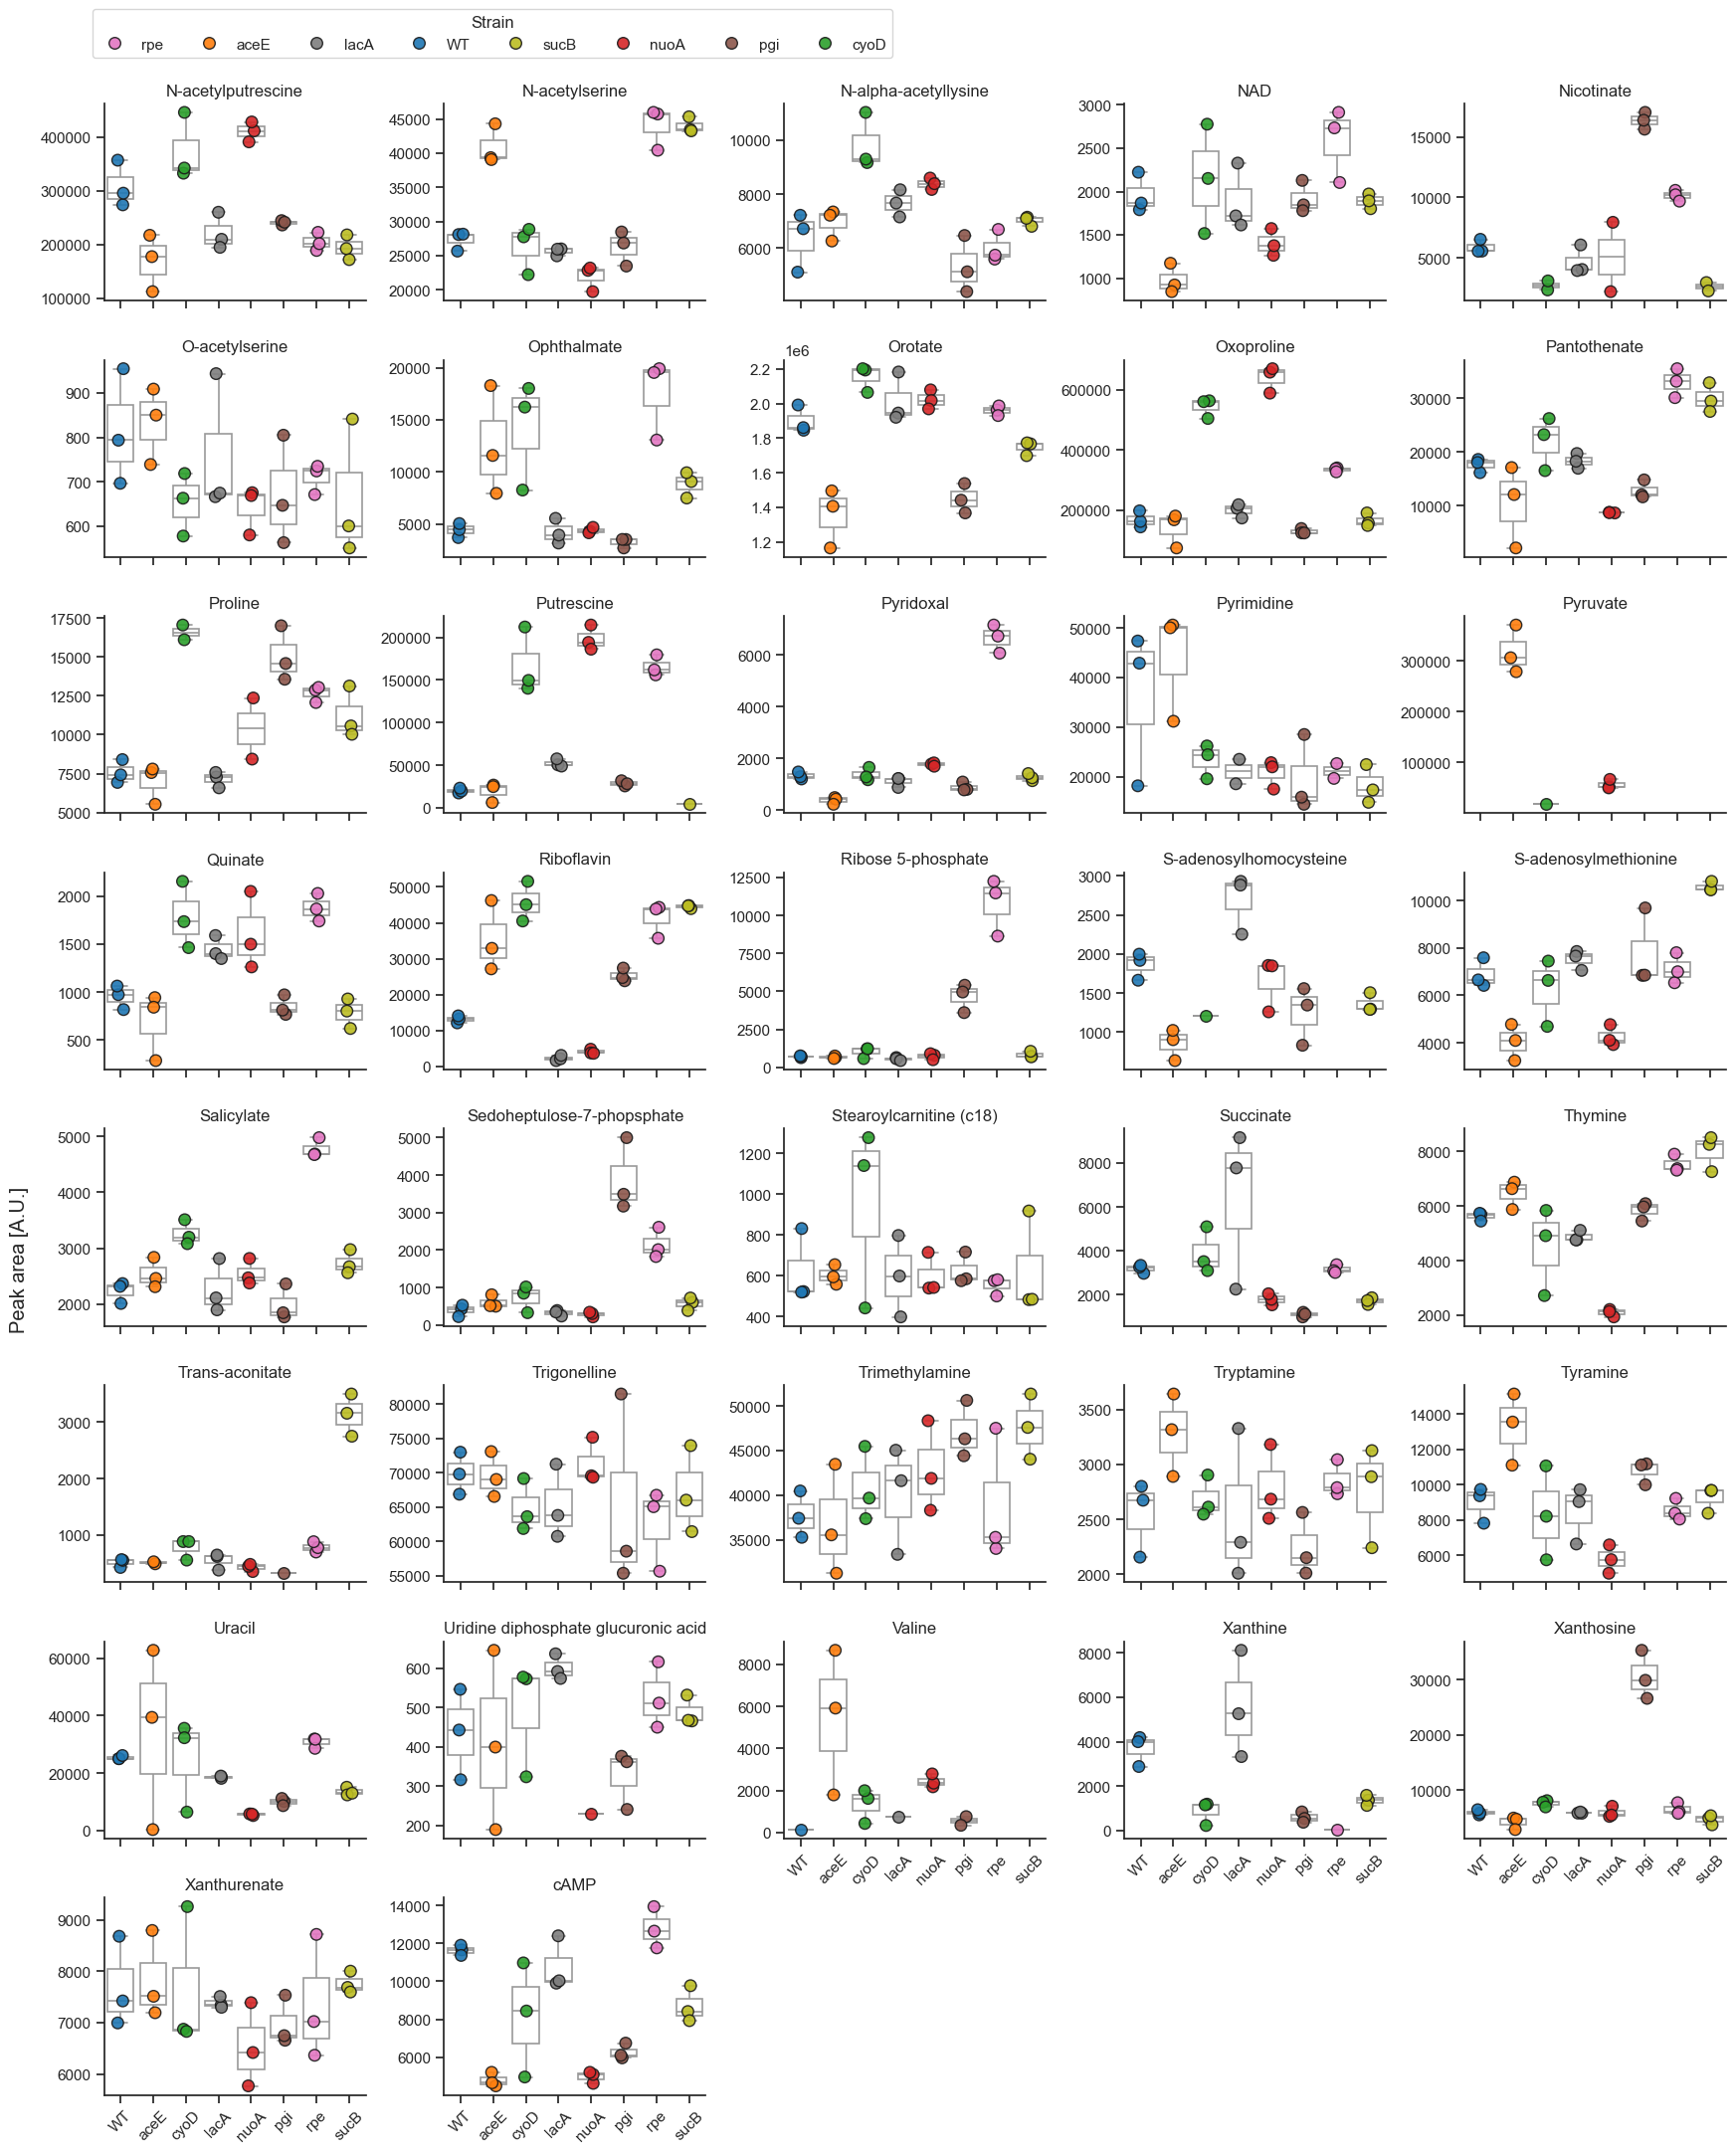

In [49]:
# sns.set_theme(font_scale=1.2, style='ticks')
idx3 = dfL_counts.Metabolite.isin(third)

g = sns.catplot(data = dfL_counts.loc[idx3], x = 'Strain', y = 'Counts', hue = 'Strain', order = exo_strains, palette=strain_colors,
            col = 'Metabolite',col_wrap=5, sharey=False, s = 70, alpha = 0.9, linewidth = 1, edgecolor='k',height=3, aspect=1.2,legend = True)
g.map_dataframe(sns.boxplot, x = 'Strain', y = 'Counts',color = 'w', fliersize = 0, linewidth = 1.2)
g.set_titles(col_template="{col_name}")
# Rotate x-tick labels for all axes
for ax in g.axes.flat:
    # if (ax.get_ylim()[1]/ax.get_ylim()[0] > 10) or ((ax.get_ylim()[0] <=0) and (ax.get_ylim()[1] > 100)):
    # ax.set_yscale('log')
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('center')
sns.move_legend(g, loc = 'lower left', bbox_to_anchor = (0.06,1), ncol = 8, frameon = True)

g.set_axis_labels('', '')
g.fig.supylabel('Peak area [A.U.]')
plt.subplots_adjust(wspace=0.3, hspace=0.3, left = 0.07, bottom=0.15)
plt.savefig(figure_folder / 'KEIO_KO_exometabolome_counts_3.pdf', bbox_inches='tight')
plt.savefig(figure_folder / 'KEIO_KO_exometabolome_counts_3.png', bbox_inches='tight', dpi = 300)

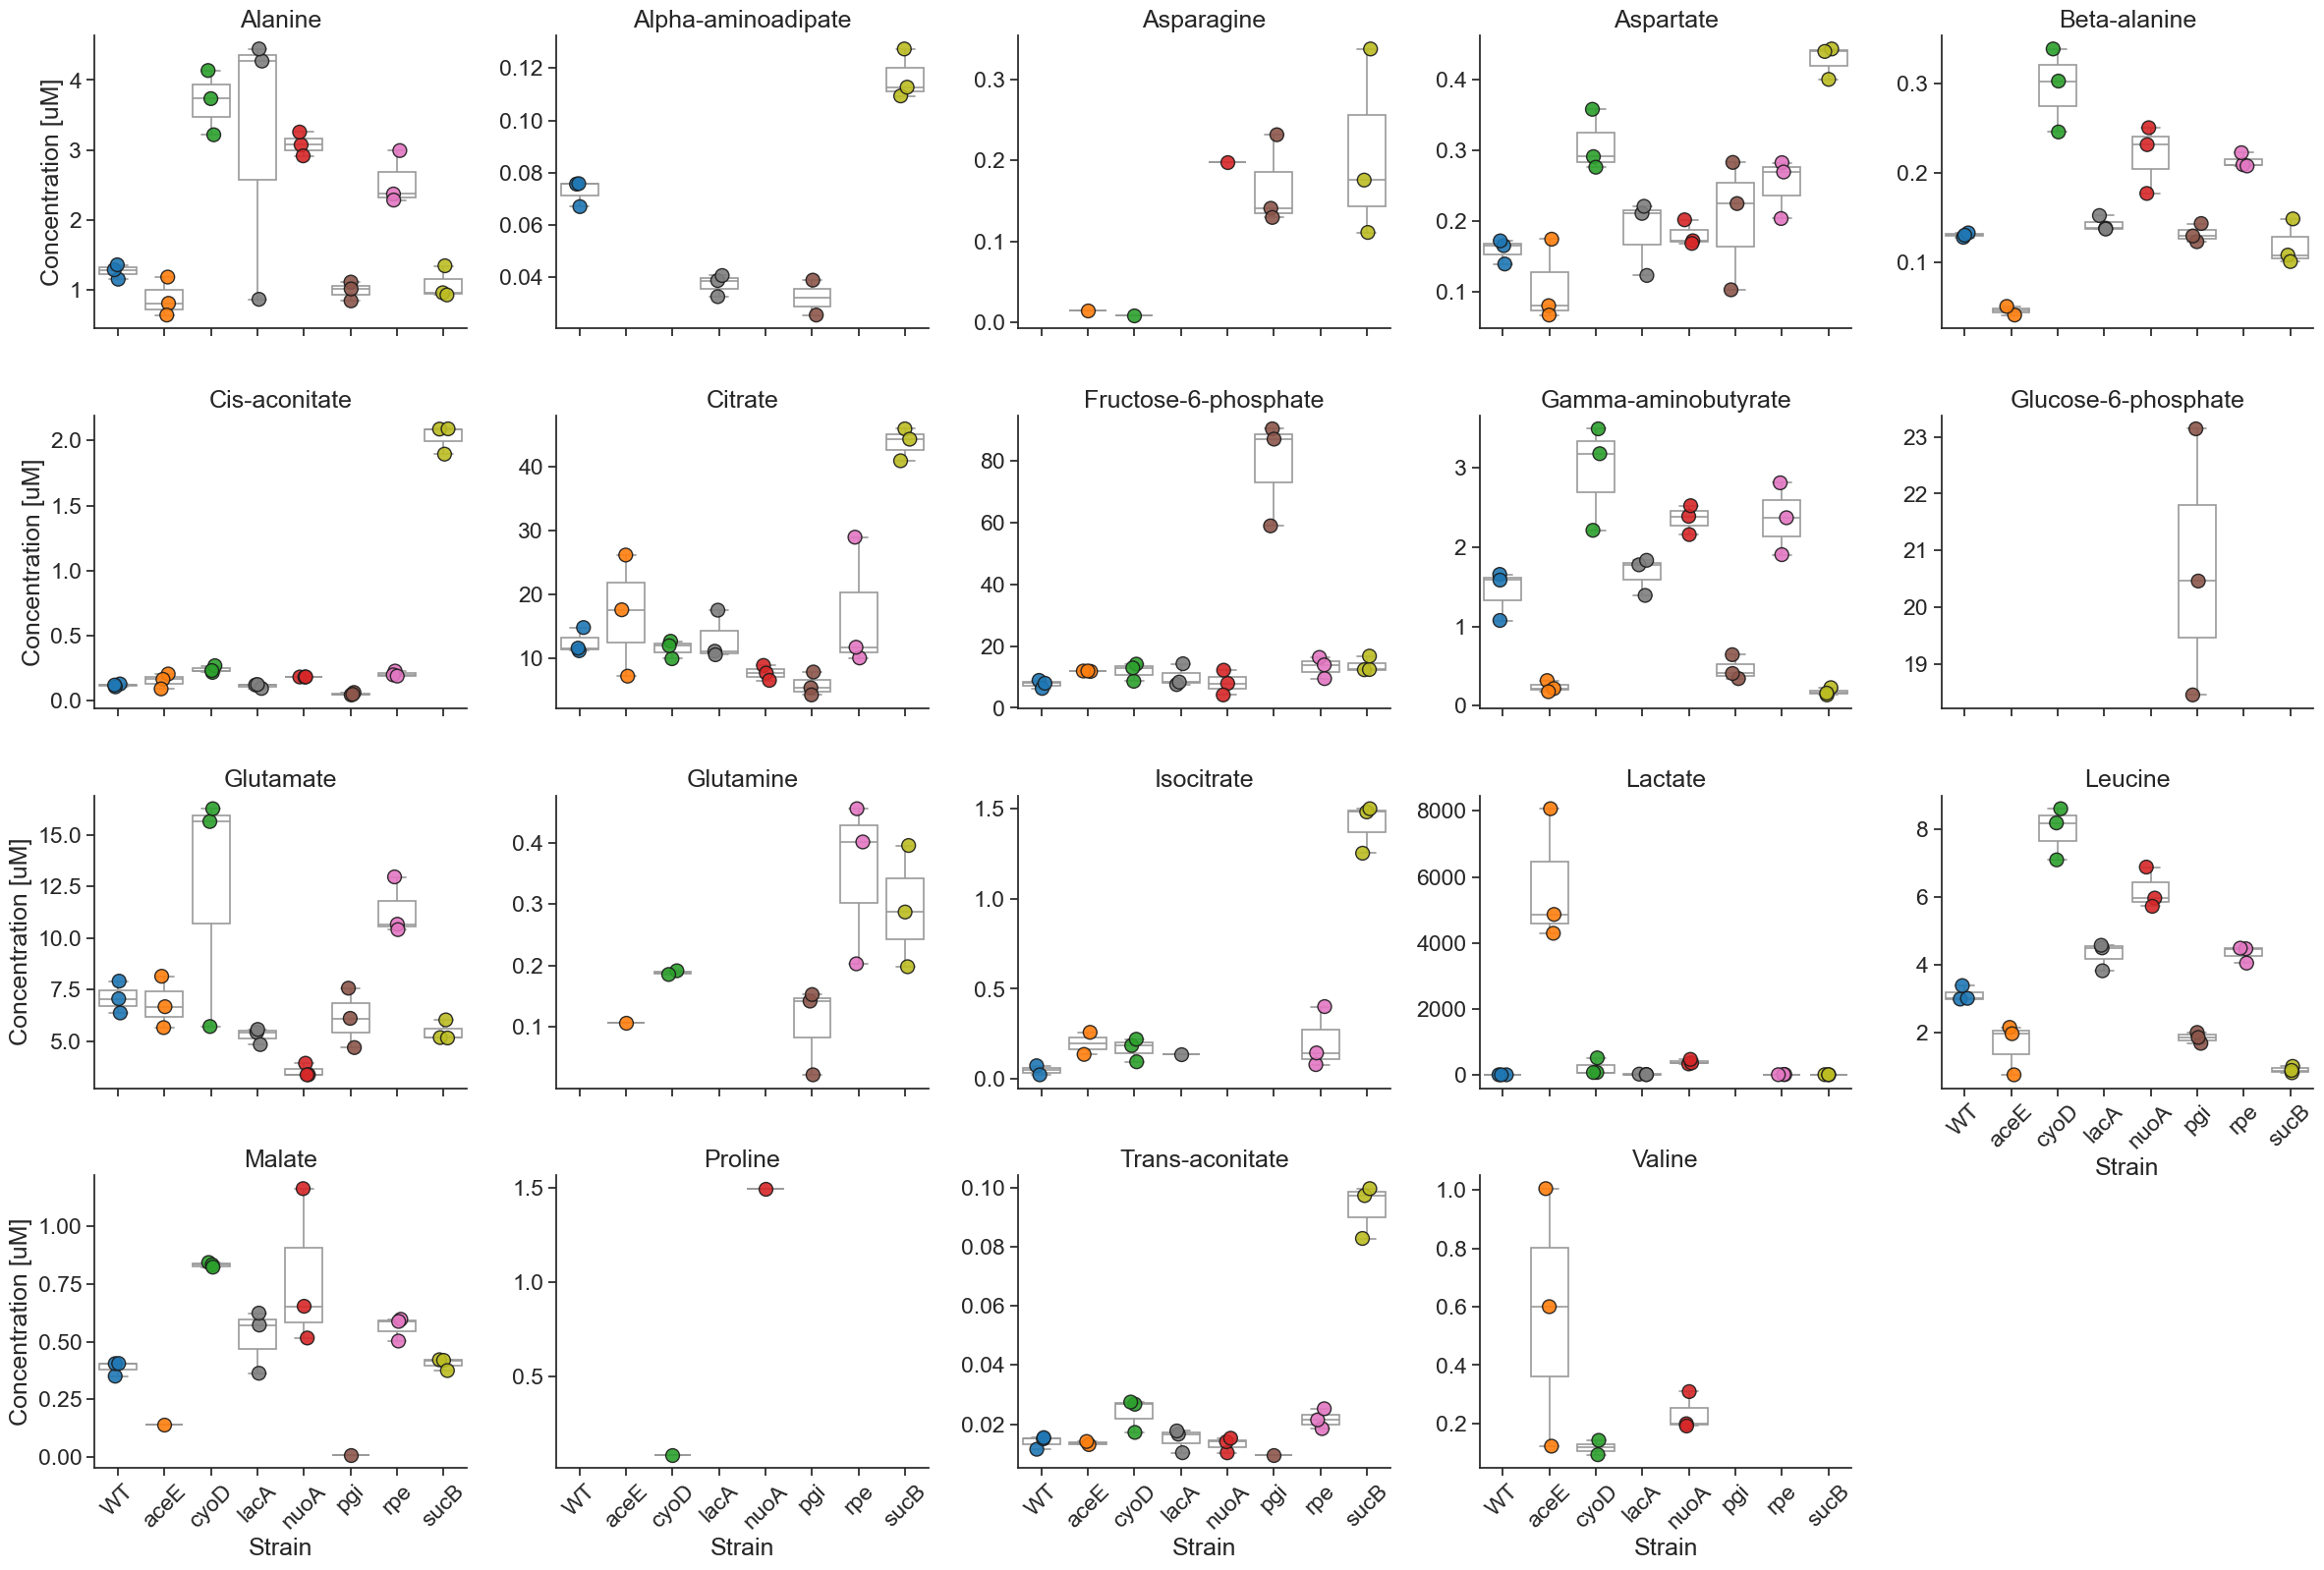

In [50]:
sns.set_theme(font_scale=1.5, style='ticks')
g = sns.catplot(data = dfL_uM, x = 'Strain', y = 'Concentration [uM]', hue = 'Strain', order = exo_strains, palette=strain_colors,
            col = 'Metabolite',col_wrap=5, sharey=False, s = 100, alpha = 0.9, linewidth = 1, edgecolor='k',height=4, aspect=1.2,)
g.map_dataframe(sns.boxplot, x = 'Strain', y = 'Concentration [uM]',color = 'w', fliersize = 0, linewidth = 1.2)
g.set_titles(col_template="{col_name}")
# Rotate x-tick labels for all axes
for ax in g.axes.flat:
    # if (ax.get_ylim()[1]/ax.get_ylim()[0] > 10) or ((ax.get_ylim()[0] <=0) and (ax.get_ylim()[1] > 100)):
    # ax.set_yscale('log')
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('center')
plt.savefig(figure_folder / 'KEIO_KO_exometabolome_uM.pdf', bbox_inches='tight')
plt.savefig(figure_folder / 'KEIO_KO_exometabolome_uM.png', bbox_inches='tight', dpi = 300)

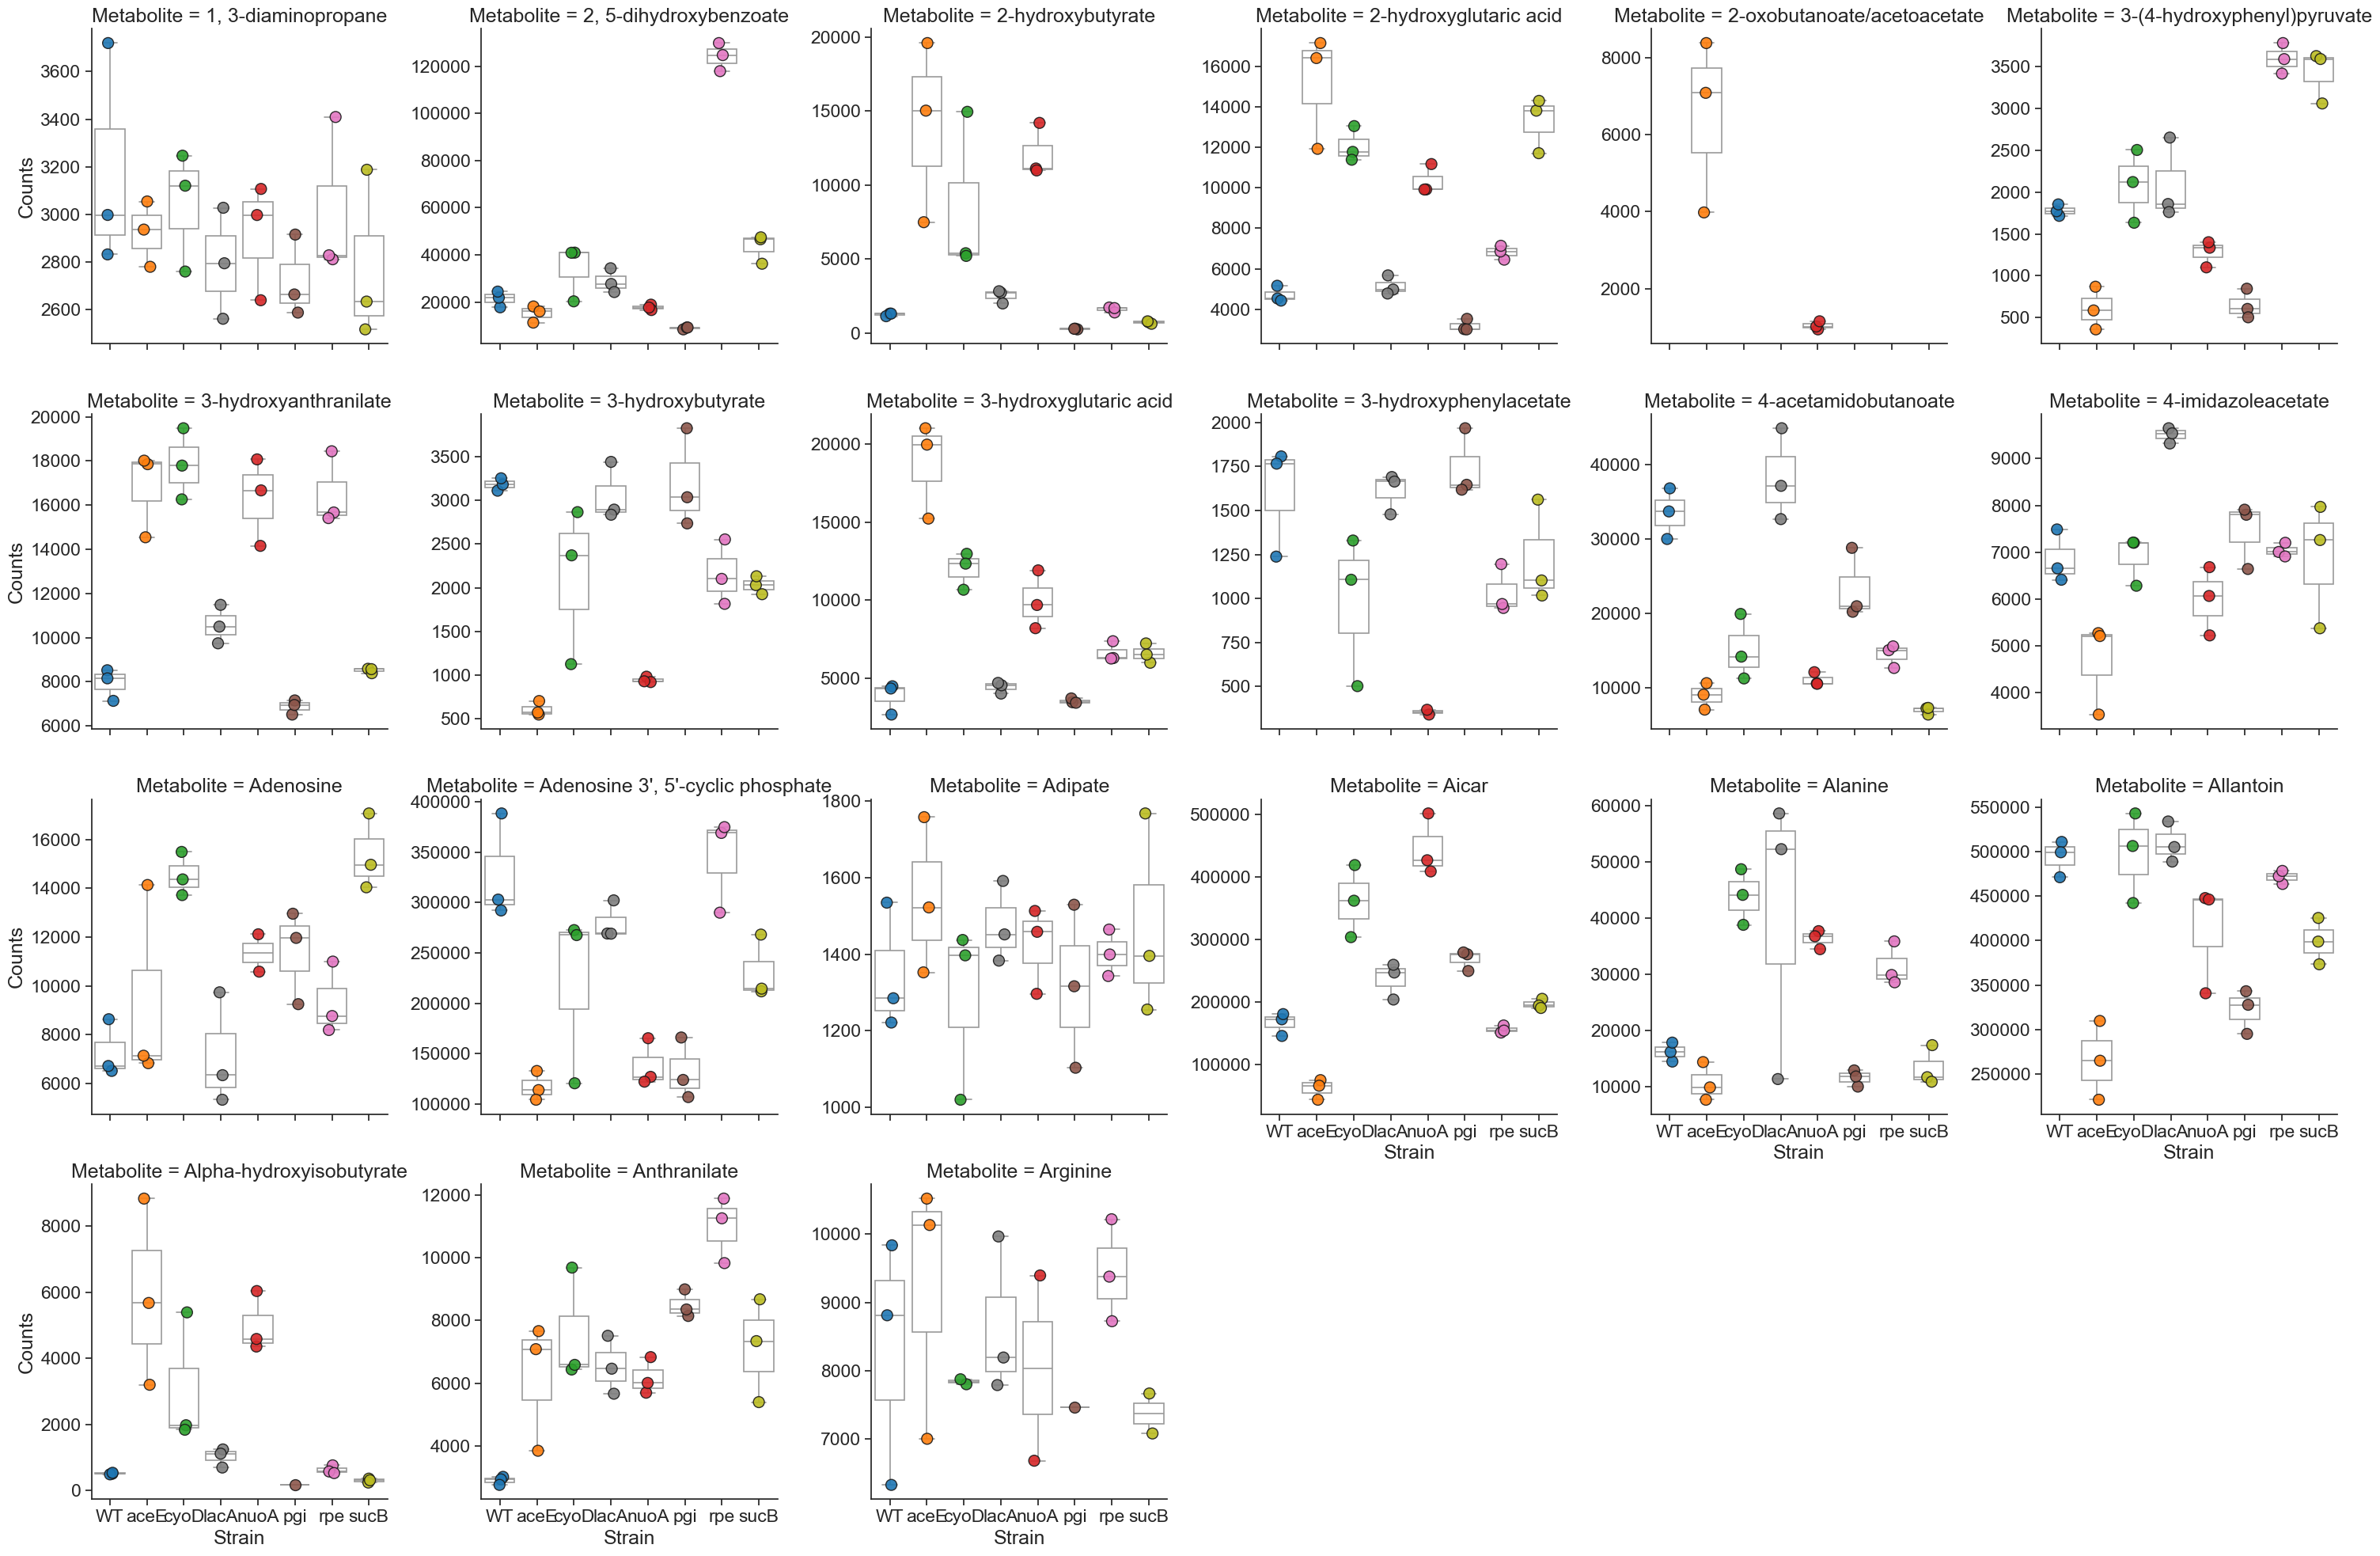

In [51]:
g = sns.catplot(data = dfL_counts.iloc[:500], x = 'Strain', y = 'Counts', hue = 'Strain', order = exo_strains, palette=strain_colors,
            col = 'Metabolite',col_wrap=6, sharey=False, s = 100, alpha = 0.9, linewidth = 1, edgecolor='k',)
g.map_dataframe(sns.boxplot, x = 'Strain', y = 'Counts',color = 'w', fliersize = 0, linewidth = 1.2)

# Read in metabolomics data from Fuhrer et al

In [52]:
metabolomics_folder = Path('../../data/fuhrer_2017/')
neg_zscore = pd.read_csv(metabolomics_folder/'zscore_neg.tsv', sep = '\t', header=None)
pos_zscore = pd.read_csv(metabolomics_folder/'zscore_pos.tsv', sep = '\t', header=None)
zscores = pd.concat([neg_zscore, pos_zscore])
met_info = pd.read_csv(metabolomics_folder / 'metabolite_info.csv')
met_info = met_info.iloc[1:,:4]
sample_info = pd.read_csv(metabolomics_folder / 'strain_ids.csv', header=None)
zscores.columns = [x[0] for x in sample_info.values]

In [53]:
met_info.head(20)

Ionization Mode  Ion Index     m/z  \
1              neg        1.0  56.996   
2              neg        2.0  57.035   
3              neg        3.0  57.056   
4              neg        4.0  58.038   
5              neg        5.0  59.014   
6              neg        6.0  59.050   
7              neg        7.0  59.071   
8              neg        8.0  59.105   
9              neg        9.0  59.146   
10             neg       10.0  59.986   
11             neg       11.0  60.017   
12             neg       12.0  60.054   
13             neg       13.0  60.993   
14             neg       14.0  61.015   
15             neg       15.0  61.054   
16             neg       16.0  61.091   
17             neg       17.0  61.989   
18             neg       18.0  61.997   
19             neg       19.0  62.998   
20             neg       20.0  68.996   

   Annotations (Compound Name, Modification, Sum-Formula, KEGG Code, HMDB Code)  
1                                       no annotation                            
2    2-Oxobutanoate -CO2-H(+) C4H6O3 C00109 HMDB00005                            
3                                       no annotation                            
4            Acetone [+1]-H(+) C3H6O C00207 HMDB01659                            
5               Acetate -H(+) C2H4O2 C00033 HMDB00042                            
6   4-Hydroxybutanoic acid -CO2-H(+) C4H8O3 C00989...                            
7                                       no annotation                            
8                                       no annotation                            
9                                       no annotation                            
10                  HCO3- -H(+) HCO3 C00288 HMDB00595                            
11          Acetate [+1]-H(+) C2H4O2 C00033 HMDB00042                            
12            Propan-2-ol [+1]-H(+) C3H8O C01845 n.a.                            
13                    CO2 +OH(-) CO2 C00011 HMDB01967                            
14                                      no annotation                            
15            Propan-2-ol [+2]-H(+) C3H8O C01845 n.a.                            
16                                      no annotation                            
17                Nitrate -H(+) HNO3 C00244 HMDB02878                            
18                CO2 [+1]+OH(-) CO2 C00011 HMDB01967                            
19     Carbonic acid [+2]-H(+) H2CO3 C01353 HMDB03538                            
20           Propynoate -H(+) C3H2O2 C00804 HMDB06804

In [54]:
for i, row in met_info.iterrows():
    annotations = row['Annotations (Compound Name, Modification, Sum-Formula, KEGG Code, HMDB Code)'].split(' ')
    if annotations[0] == 'no':
        continue
    else:
        if len(annotations) > 5:
            j = len(annotations) - 5
            name = ' '.join(annotations[:j+1])
            print(name)
        elif len(annotations) == 5:
            name = annotations[0]
            j = 0

        if len(annotations) >= 5:
            met_info.at[i, 'Name'] = name
            met_info.at[i, 'Sum-Formula'] = annotations[2+j]
            met_info.at[i, 'KEGG Code'] = annotations[3+j]
            met_info.at[i, 'HMDB Code'] = annotations[4+j]
        else:
            break


4-Hydroxybutanoic acid
Carbonic acid
Butanoic acid
3-Methyl-2-oxobutanoic acid
L-Aspartate 4-semialdehyde
Carbonic acid
Ethylene glycol
Butanoic acid
Glycerone phosphate
3-Methylbutanoic acid
4-Hydroxybutanoic acid
Benzyl alcohol
3-Methyl-2-oxobutanoic acid
3-Methyl-2-oxobutanoic acid
Benzyl alcohol
Octanoic acid
3-Methyl-2-oxobutanoic acid
Coniferyl alcohol
3-Methyl-2-oxobutanoic acid
Acetyl phosphate
Choline phosphate
2-Hydroxymuconate semialdehyde
cis-2-Carboxycyclohexyl-acetic acid
Octanoic acid
Octanoic acid
Cinnamyl alcohol
3-(Methylthio)propionic acid
Acetyl phosphate
Nitrous oxide
2-Hydroxymuconate semialdehyde
Sinapyl alcohol
Glycerone phosphate
9-Oxononanoic acid
Coniferyl aldehyde
Coniferyl alcohol
Carbonic acid
Ethylene glycol
Choline phosphate
Glycerone phosphate
sn-Glycerol 3-phosphate
Decanoic acid
D-Gluconic acid
Carbonic acid
Coniferyl alcohol
D-Erythrose 4-phosphate
Coniferyl aldehyde
Decahydro-2-naphthoic acid
Dodecanoic acid
Dihydroclavaminic acid
Dodecanoic acid
D-

In [55]:
zscores.index = met_info.Name

In [56]:
met_info['Name'].to_csv(metabolomics_folder / 'metabolite_names.csv', index = False)

In [57]:
pd.Series(z_metabolites).to_csv(data_folder_1 / 'metabolite_names.csv', index = False)

## Map 


In [58]:
# Redo mapping, only focusing on protonated metabolites 

In [59]:
metabolite_mapping = pd.read_csv(metabolomics_folder/'metabolite_mapping.csv').iloc[:, :2]
metabolite_mapping.columns = ['Ex name', 'In name']

In [60]:
met_map = metabolite_mapping.set_index('Ex name')['In name'].to_dict()

In [61]:
data_comp = []
for strain in exo_strains_x_wt:
    for m in z_metabolites:
        m_in = met_map[m]
        ex_zscores = df_z_scores.loc[df_z_scores.Strain == strain, m].mean()
        ex_wt_zscores = df_z_scores.loc[df_z_scores.Strain == 'WT', m].mean()

        in_zscores = zscores.at[m_in, strain]
        in_wt_zscores = zscores.at[m_in, 'wt']
        data_comp.append([strain, m, ex_zscores-ex_wt_zscores, (in_zscores.mean()-in_wt_zscores.mean())])
        

    

In [62]:
zscores.at[m_in, strain]

Name
3',5'-Cyclic AMP    0.5774
3',5'-Cyclic AMP    0.8344
3',5'-Cyclic AMP    0.5725
3',5'-Cyclic AMP    2.3965
3',5'-Cyclic AMP    1.2605
3',5'-Cyclic AMP    1.1067
3',5'-Cyclic AMP    1.0569
Name: lacA, dtype: float64

In [63]:
df_comp = pd.DataFrame(data_comp, columns=['Strain', 'Metabolite', 'Ex', 'In'])
df_comp.dropna(inplace=True)

PearsonRResult(statistic=np.float64(0.09099211498615731), pvalue=np.float64(0.013278648929842412))

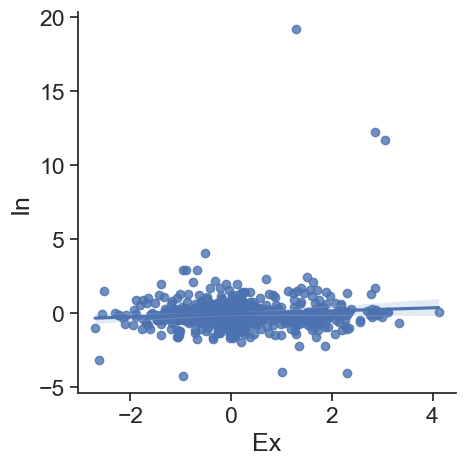

In [64]:
sns.lmplot(data = df_comp, x = 'Ex', y = 'In')
st.spearmanr(df_comp.Ex, df_comp.In)
st.pearsonr(df_comp.Ex, df_comp.In)